# Setup

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import sklearn

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.mode.chained_assignment = None

train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv').drop(columns=['Id'])
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv').drop(columns=['Id'])

In [2]:
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
train_df.head(5)

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave   NaN      Reg   
1          20       RL         80.0     9600   Pave   NaN      Reg   
2          60       RL         68.0    11250   Pave   NaN      IR1   
3          70       RL         60.0     9550   Pave   NaN      IR1   
4          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
0         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
1         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
2         Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
3         Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
4         Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

  MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
0       0      2    2008        WD         Normal     208500  
1       0      5    2007        WD         Normal     181500  
2       0      9    2008        WD         Normal     223500  
3       0      2    2006        WD        Abnorml     140000  
4       0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [4]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

# EDA

Target variable is log-normal:

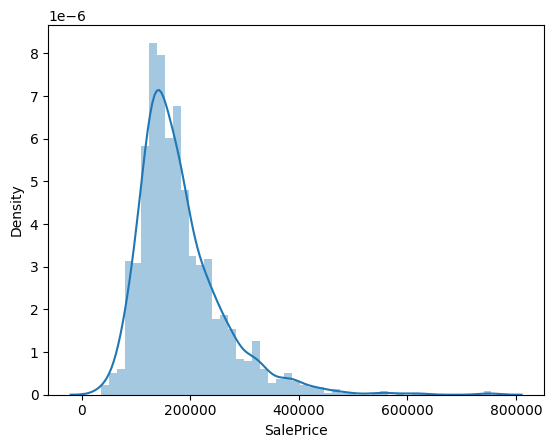

In [5]:
sns.distplot(train_df['SalePrice'])
plt.show()

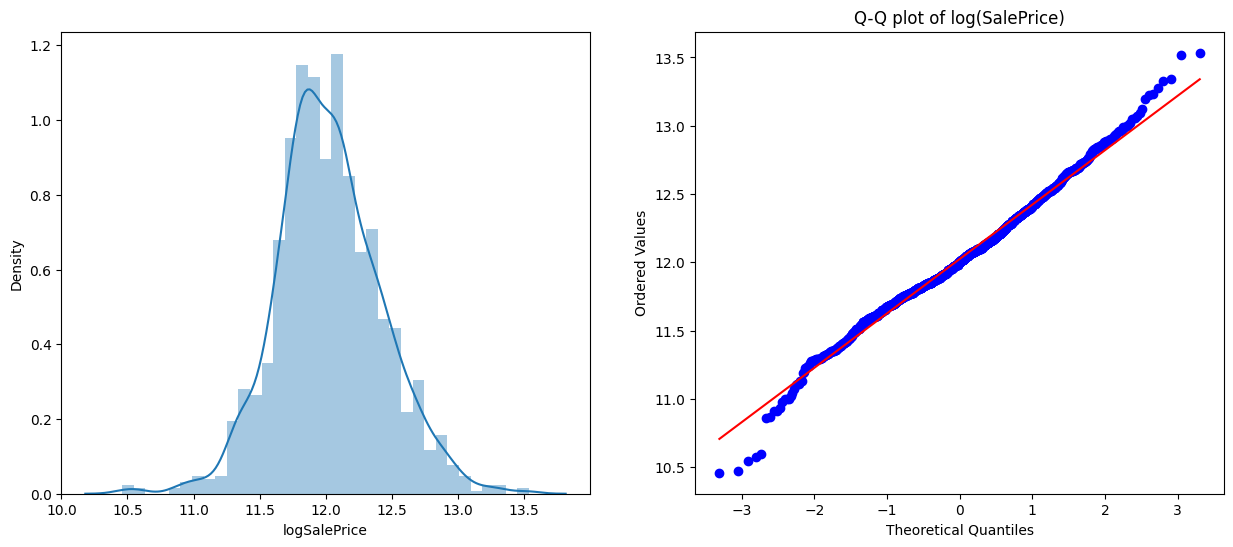

In [6]:
import scipy.stats as stats

train_df['logSalePrice'] = np.log(train_df['SalePrice'])
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(train_df['logSalePrice'], ax = axes[0])
stats.probplot(train_df['logSalePrice'], dist="norm", plot = axes[1])
axes[1].set_title(f'Q-Q plot of log(SalePrice)')
axes[1].set_xlabel("Theoretical Quantiles")
plt.show()

## Date Features

In [7]:
train_df['DateSoldMos'] = 12*train_df['YrSold']+train_df['MoSold']
train_df['DateSoldMos'] = train_df['DateSoldMos']-train_df['DateSoldMos'].min()

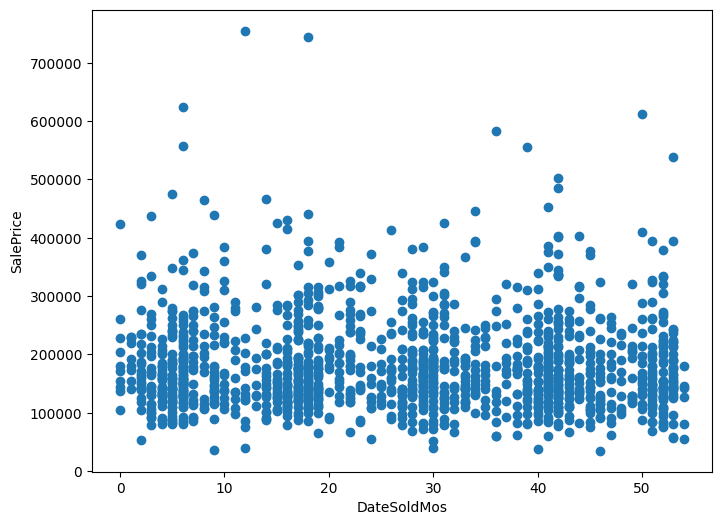

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(train_df['DateSoldMos'], train_df['SalePrice'])
plt.xlabel('DateSoldMos')
plt.ylabel('SalePrice')
plt.show()

In [9]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(train_df['DateSoldMos'].values.reshape(-1, 1), train_df['SalePrice'].values.reshape(-1, 1))
(lin.intercept_[0], lin.coef_[0,0], lin.score(train_df['DateSoldMos'].values.reshape(-1, 1), train_df['SalePrice'].values.reshape(-1, 1)))

(183825.3377895883, -107.12058948003943, 0.00045226535171571935)

No apparent trend in prices across ~5 year period

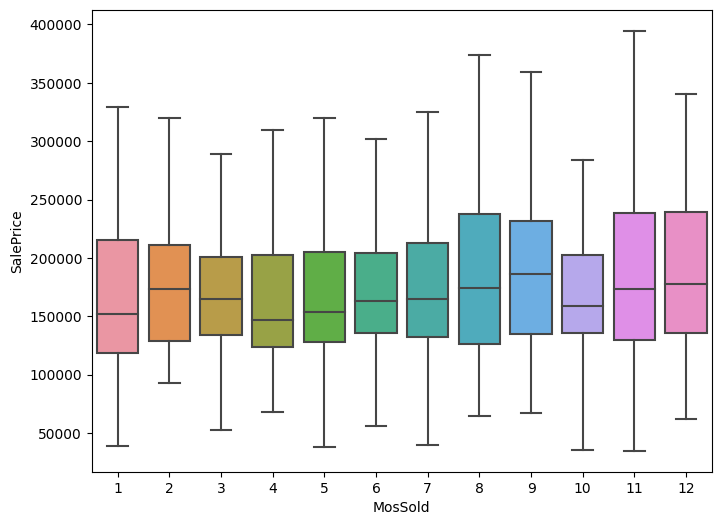

In [10]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'MoSold', y = 'SalePrice', showfliers = False, data = train_df)
plt.xlabel('MosSold')
plt.ylabel('SalePrice')
plt.show()

Mild seasonality effect by month can be observed.

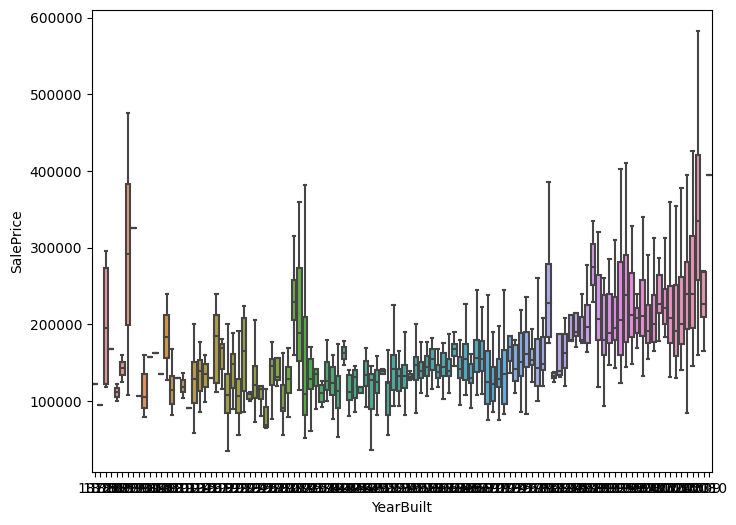

In [11]:
plt.figure(figsize=(8, 6))
sns.boxplot(x = 'YearBuilt', y = 'SalePrice', showfliers = False, data = train_df)
plt.xlabel('YearBuilt')
plt.ylabel('SalePrice')
plt.show()

Preference towards newly built homes.

## Area Features

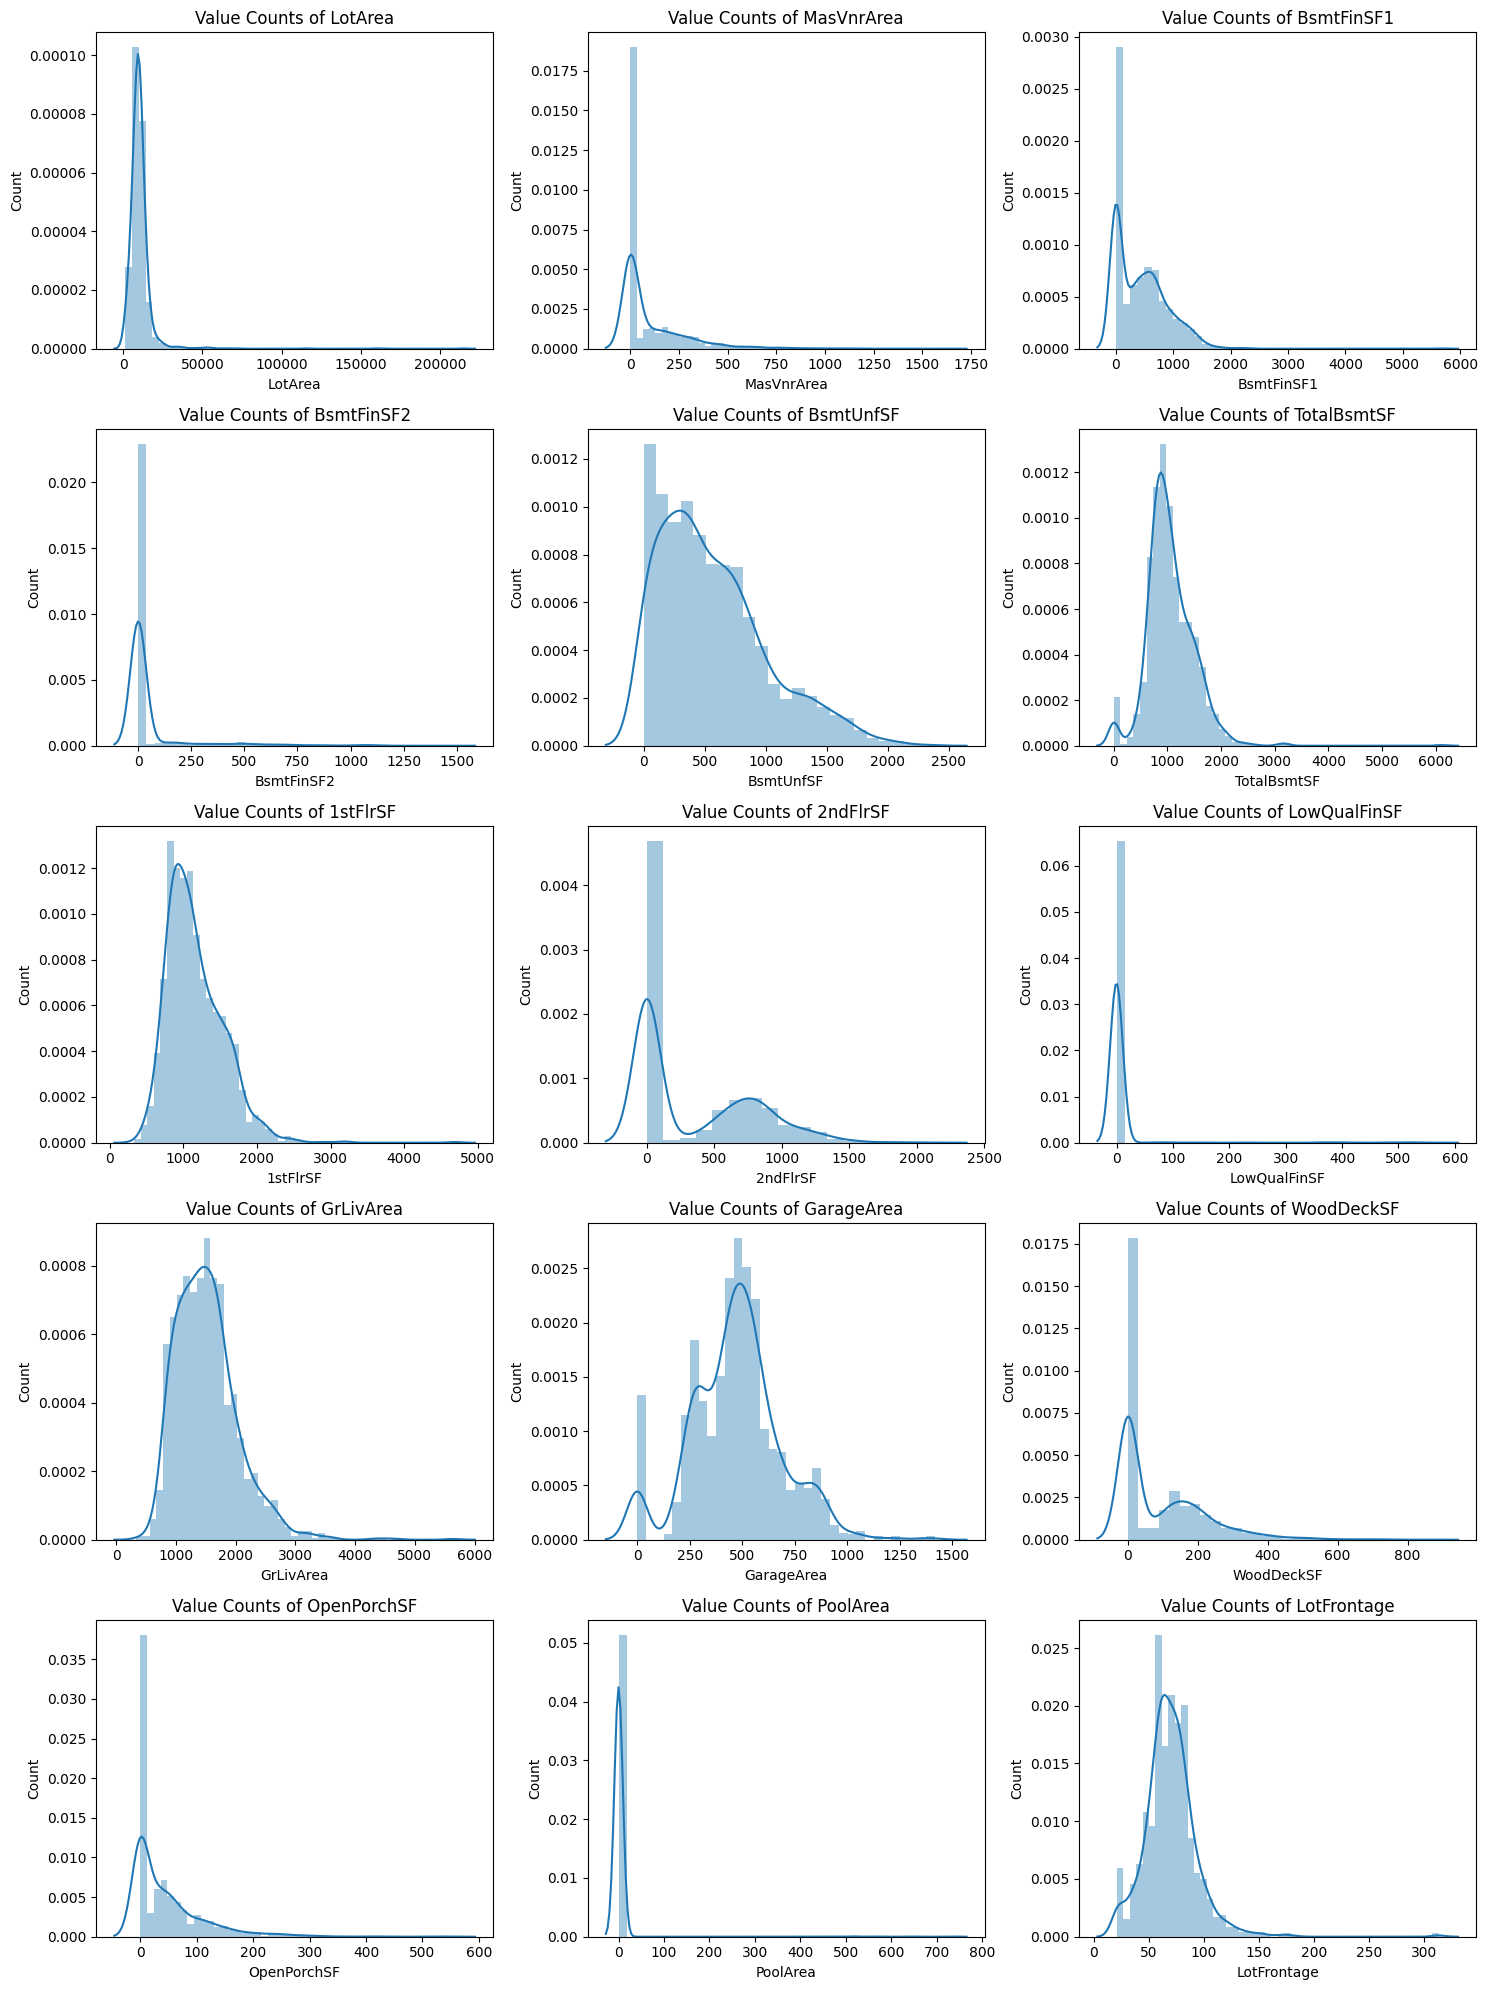

In [12]:
area_feats = [col for col in train_df.columns if ('Area' in col or 'SF' in col)] + ['LotFrontage']
plots_per_row = 3
num_rows = (len(area_feats) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(area_feats):
    sns.distplot(train_df[col], ax=axes[i])
    axes[i].set_title(f'Value Counts of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

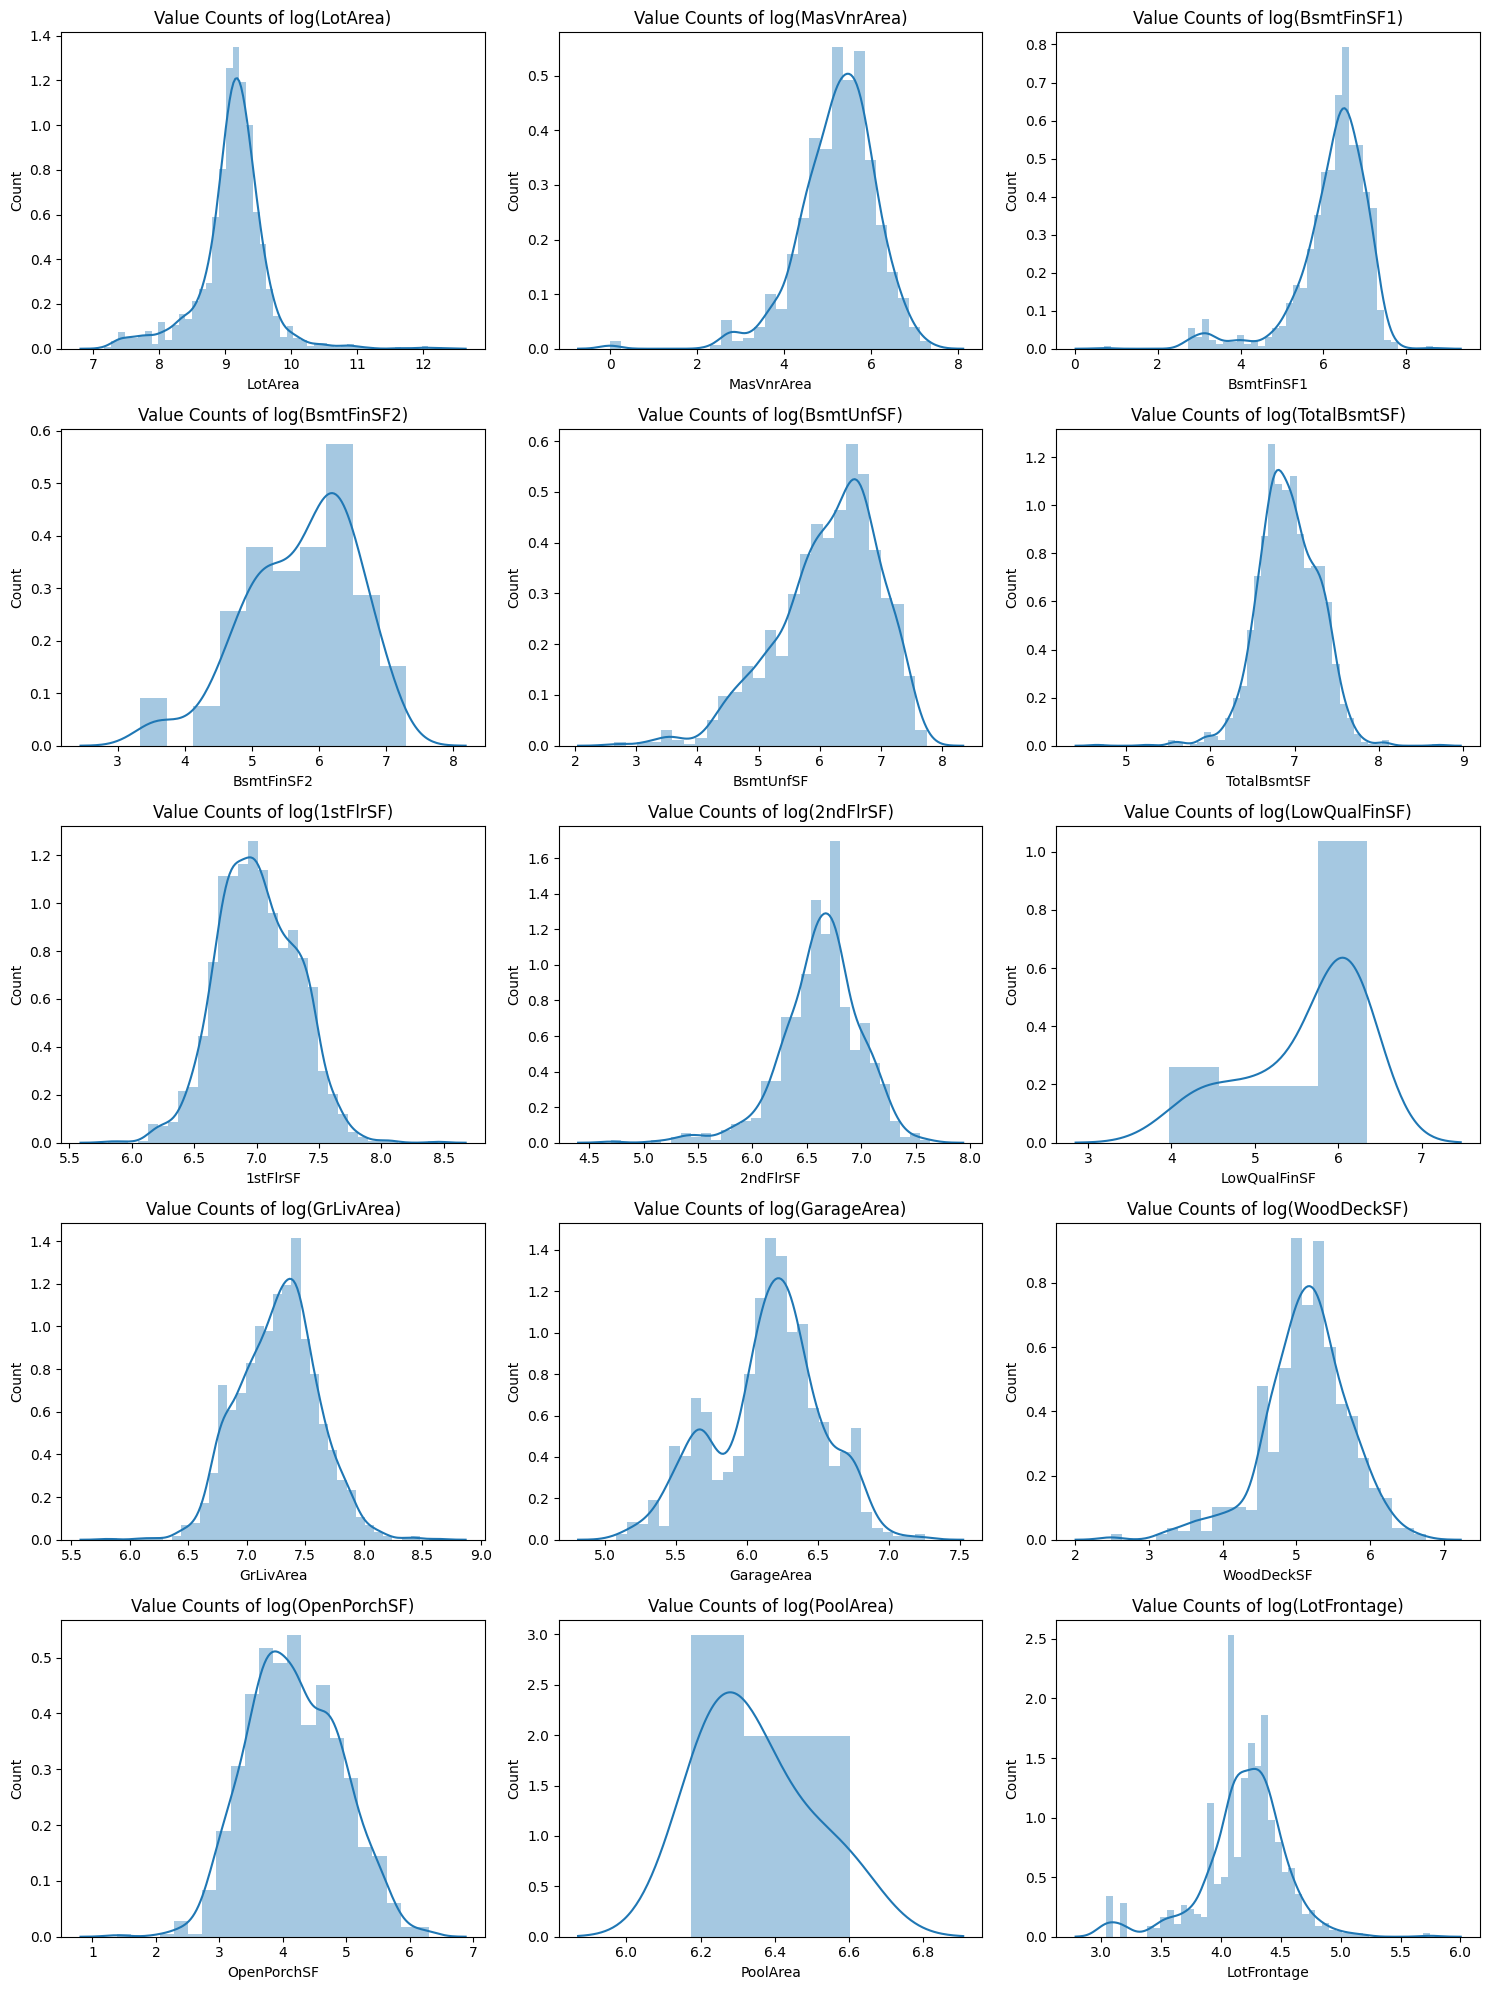

In [13]:
plots_per_row = 3
num_rows = (len(area_feats) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(area_feats):
    sns.distplot(np.log(train_df[col][(train_df[col] > 0) & (~train_df[col].isna())]), ax=axes[i])
    axes[i].set_title(f'Value Counts of log({col})')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

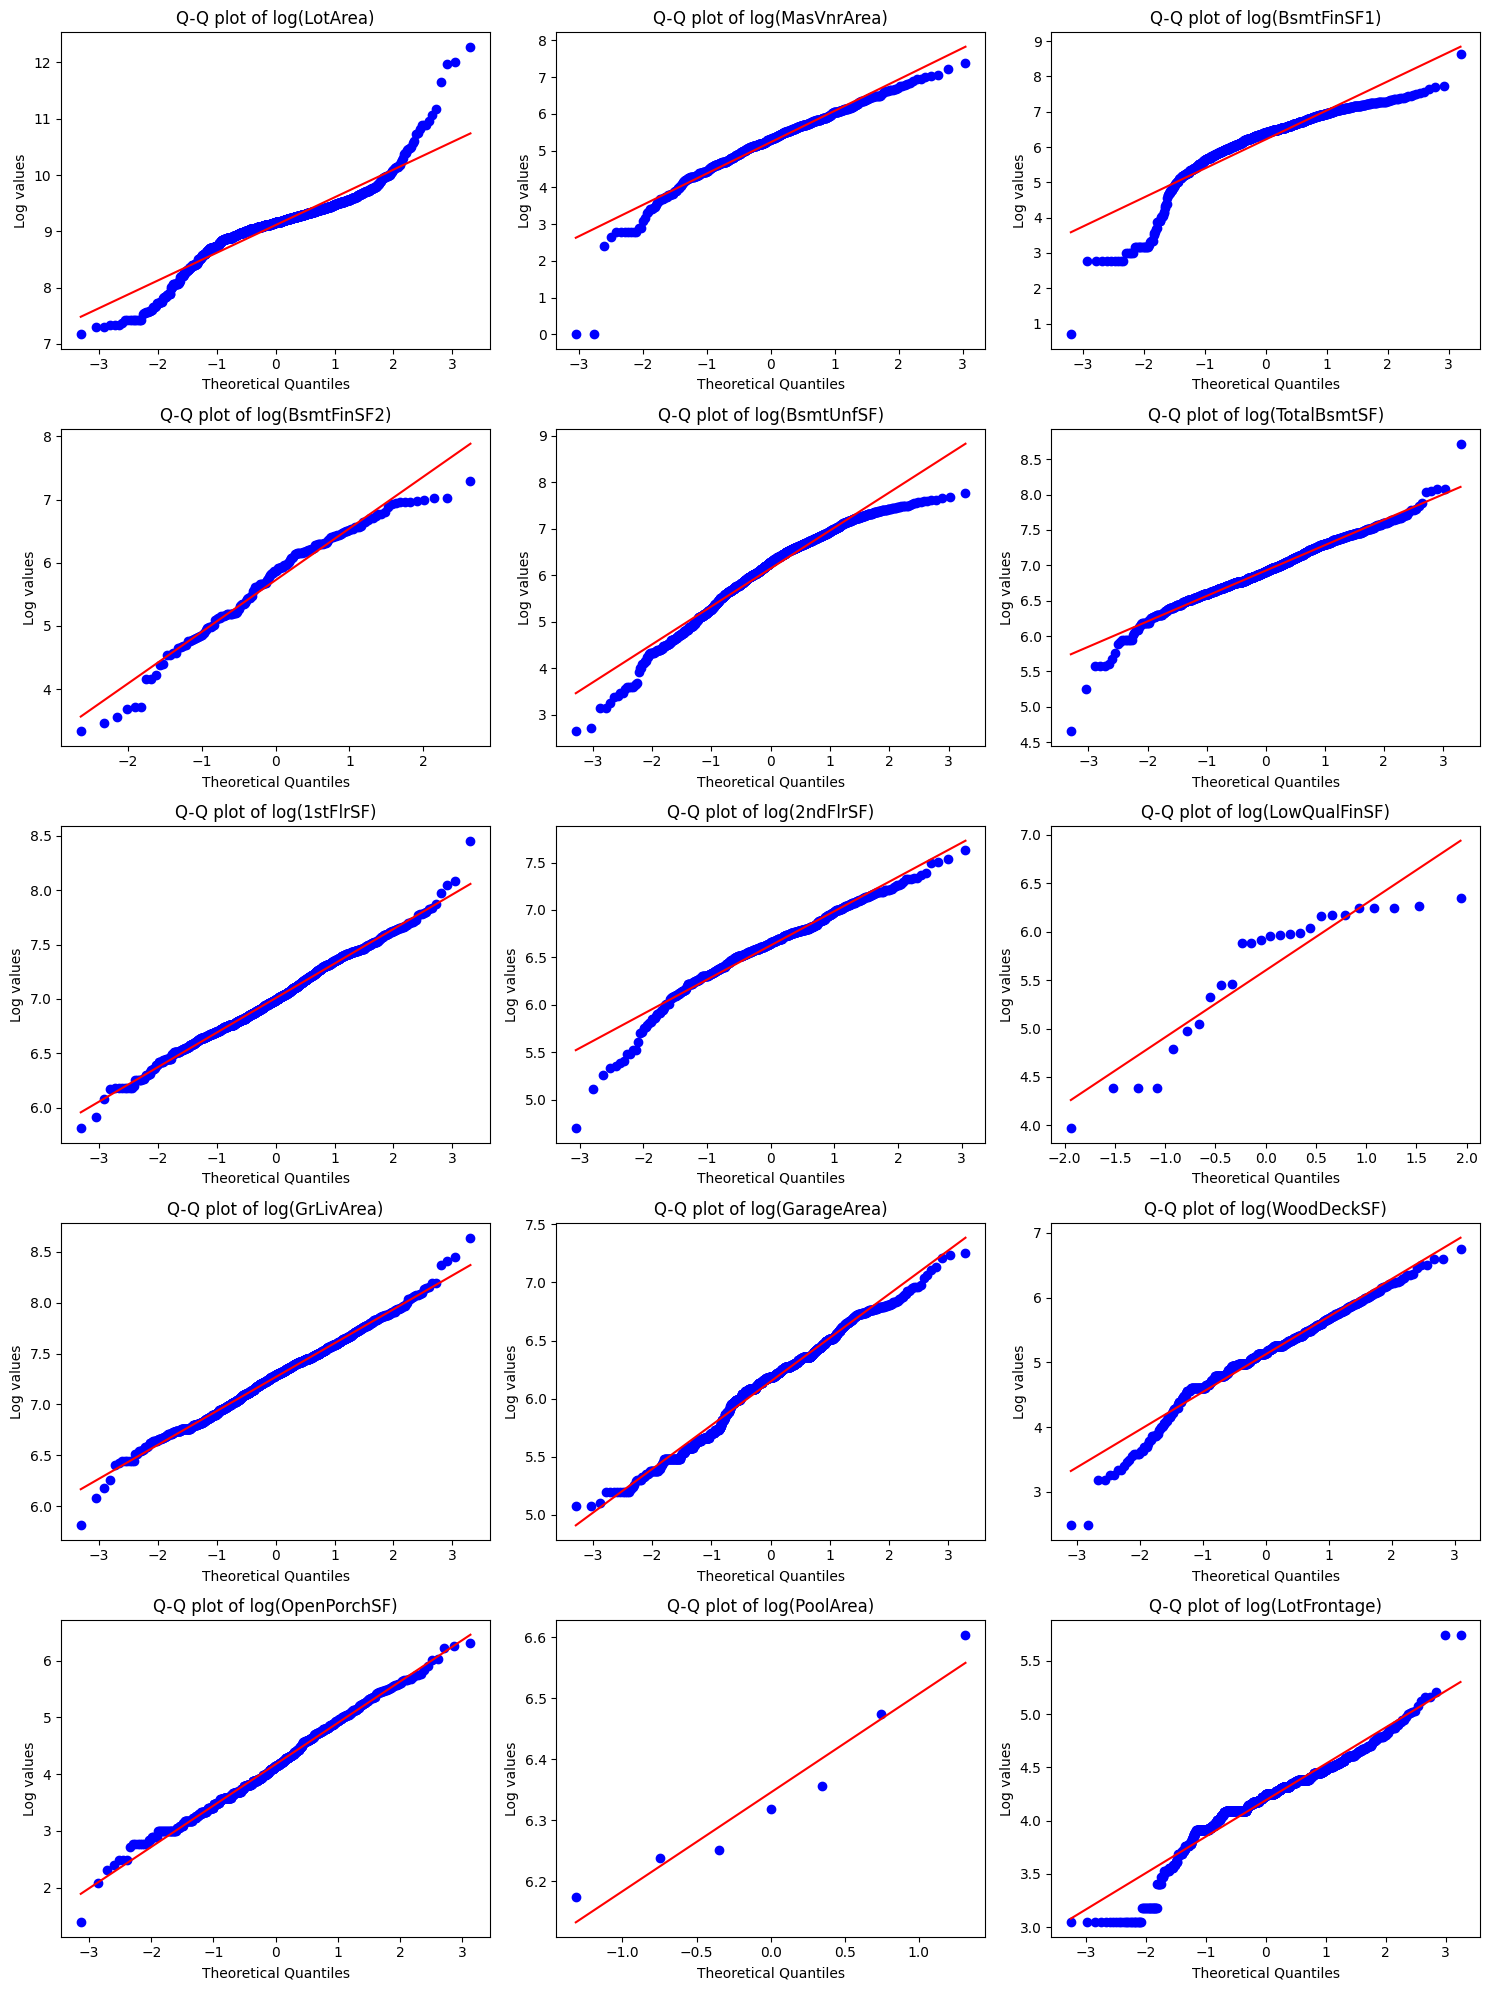

In [14]:
import scipy.stats as stats

plots_per_row = 3
num_rows = (len(area_feats) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(area_feats):
    stats.probplot(np.log(train_df[col][(train_df[col] > 0) & (~train_df[col].isna())]), dist="norm", plot=axes[i])
    axes[i].set_title(f'Q-Q plot of log({col})')
    axes[i].set_xlabel("Theoretical Quantiles")
    axes[i].set_ylabel('Log values')
    axes[i].tick_params(axis='x')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Other than unfinished basement area and porch area most area features seem linearly correlated with SalePrice

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


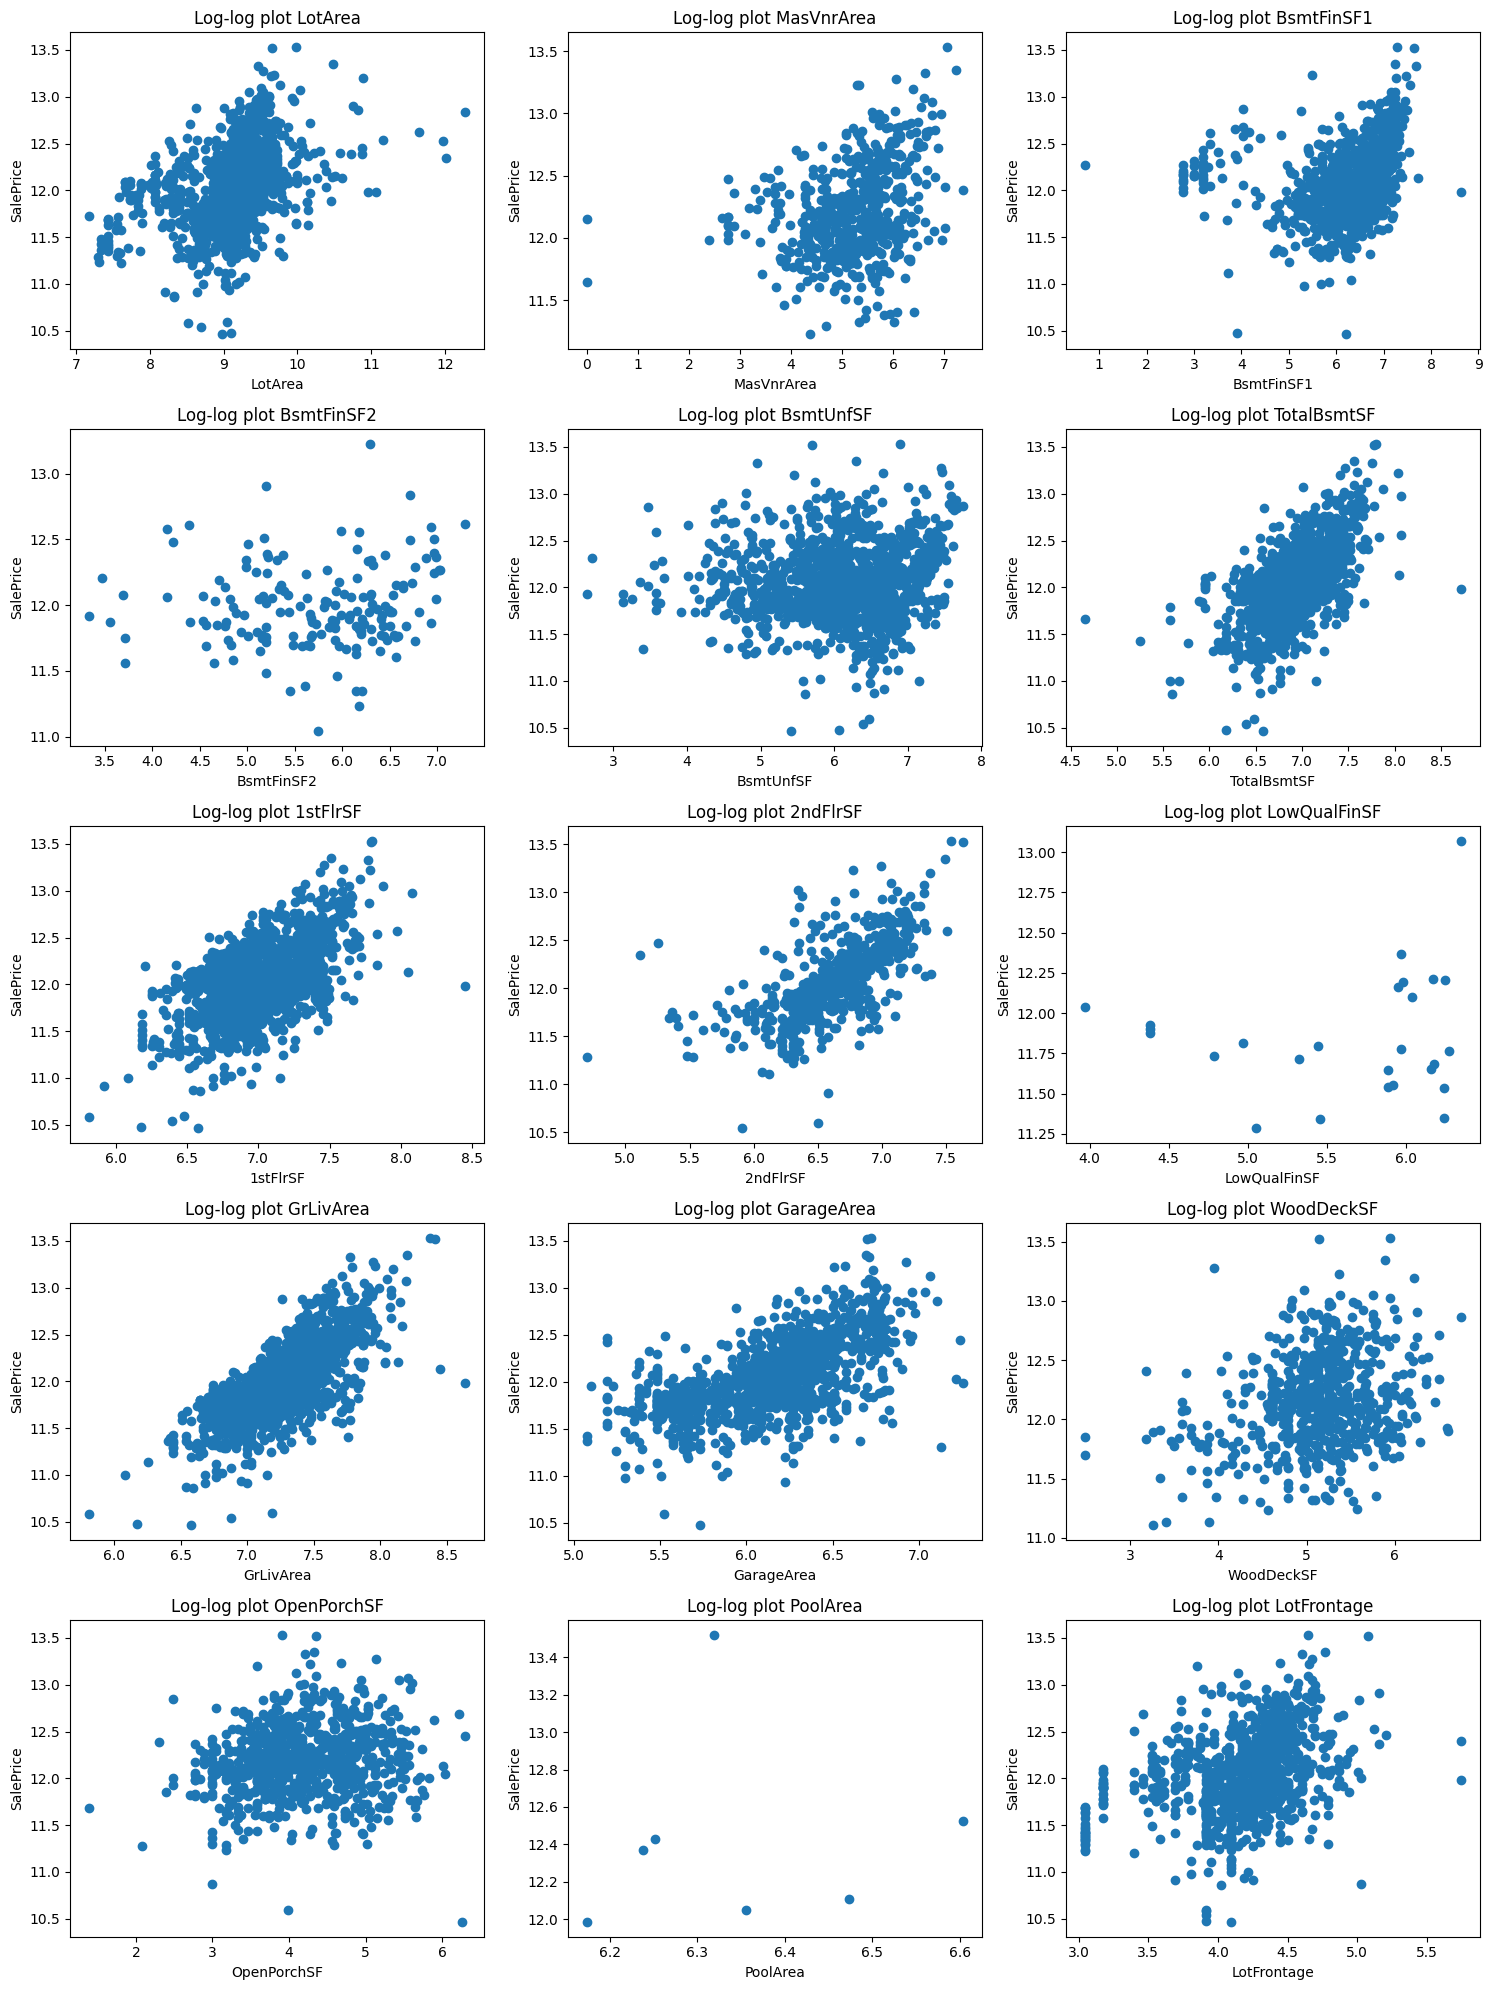

In [15]:
import scipy.stats as stats

plots_per_row = 3
num_rows = (len(area_feats) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))
axes = axes.flatten()

for i, col in enumerate(area_feats):
    axes[i].scatter(np.log(train_df[col]), train_df['logSalePrice'])
    axes[i].set_title(f'Log-log plot {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('SalePrice')
    axes[i].tick_params(axis='x')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Ordinal Features

In [47]:
ordinal_mappings = {
    'OverallQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'OverallCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'LotShape': ['IR3', 'IR2', 'IR1', 'Reg'],
    'LandContour': ['Low', 'HLS', 'Bank', 'Depression'],
    'LandSlope': ['Sev', 'Mod', 'Gtl'],
    'BsmtFinType1': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFinType2': ['Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
}

ordinal_cols = ordinal_mappings.keys()

Most houses here seem to have "average" quality ordinary features.

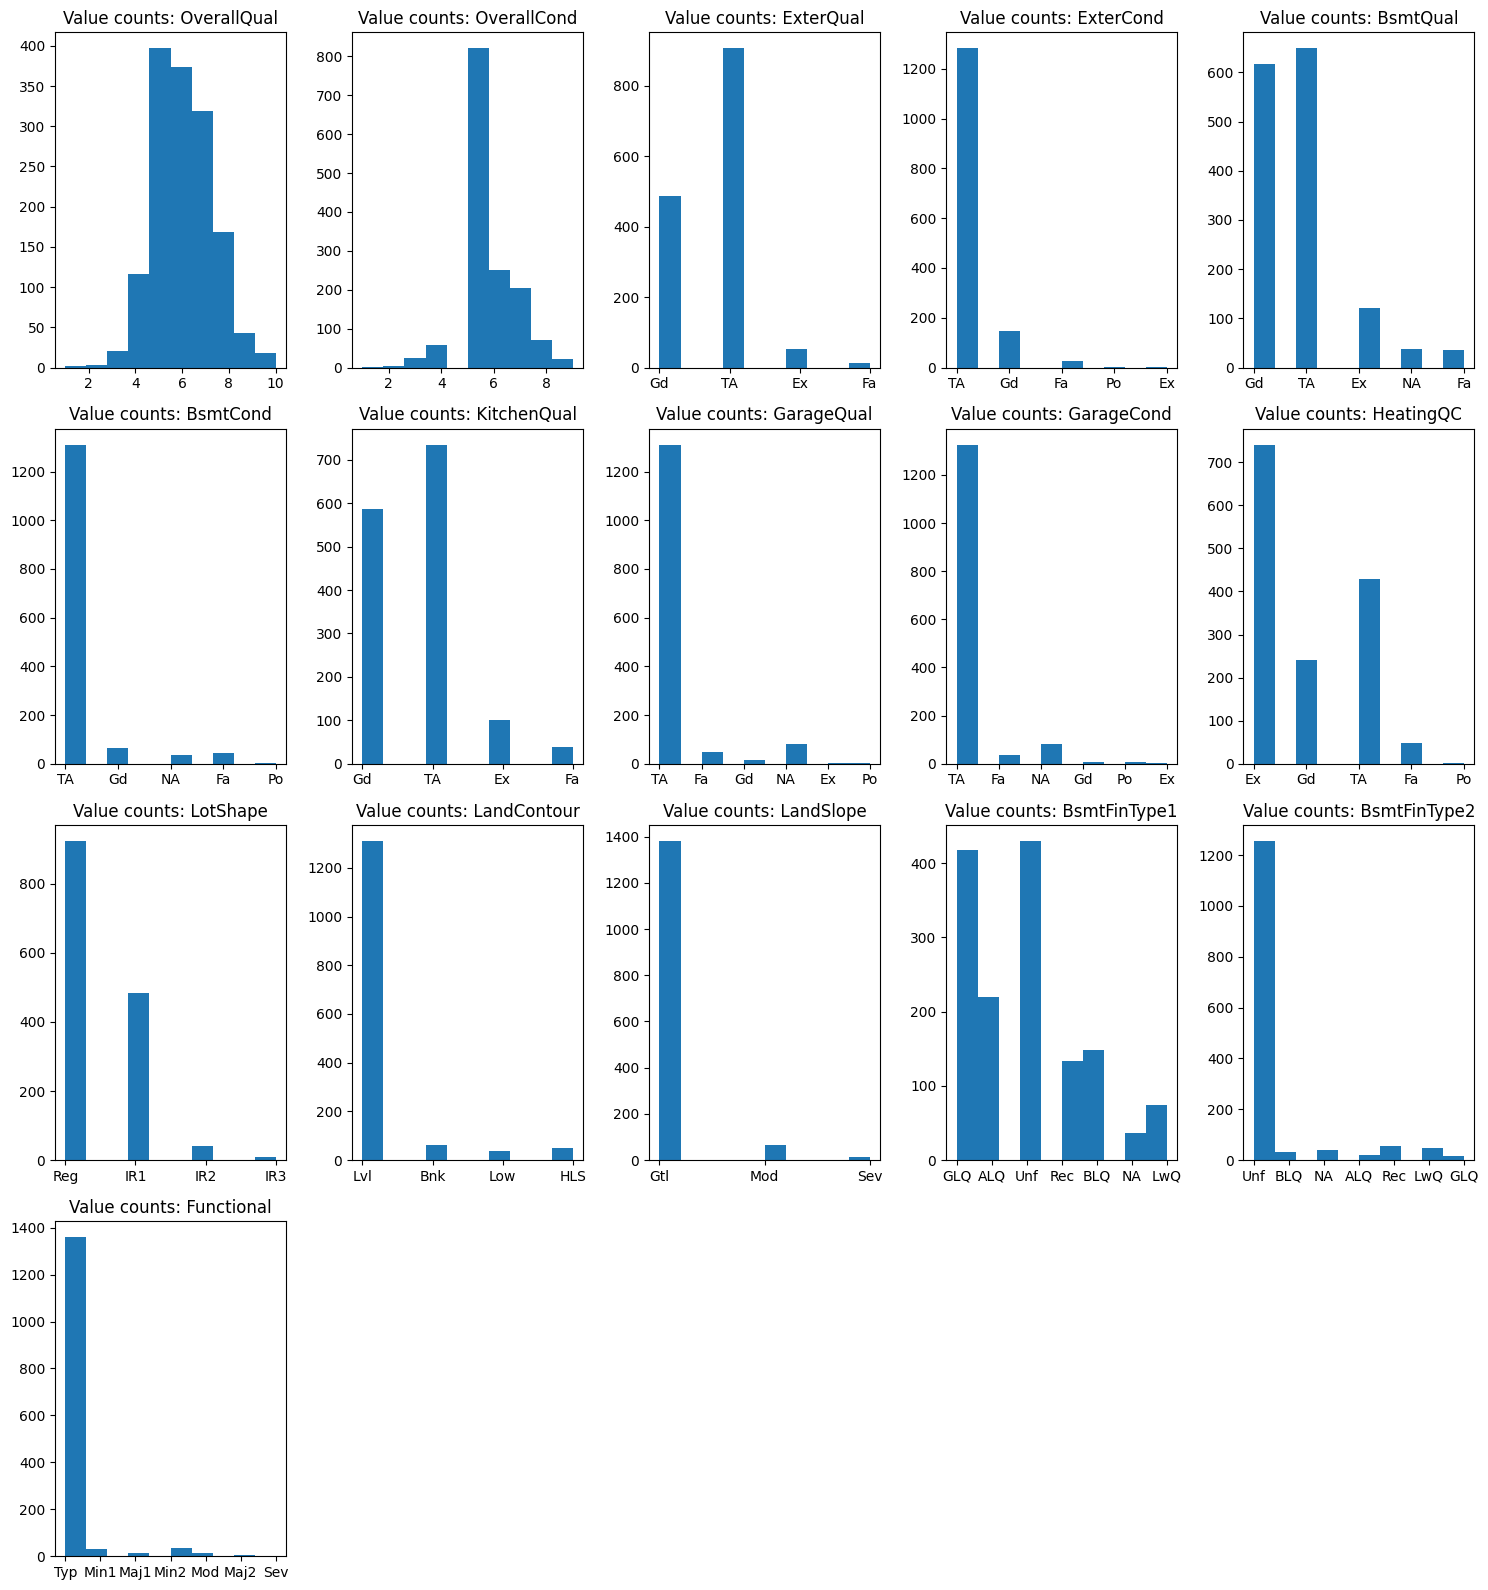

In [48]:
plots_per_row = 5
num_rows = (len(ordinal_cols) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))

axes = axes.flatten()

for i, col in enumerate(ordinal_cols):
    col_no_nan = train_df[col].dropna()
    axes[i].hist(col_no_nan)
    axes[i].set_title(f'Value counts: {col}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Qual, Cond, QC features show strong ordinal correlation to SalePrice. Surprisingly, irregular terrain/slope seem to positively correlate with SalePrice. This might be correlation rather than causation, so it is worthwhile experimenting with dropping these features.

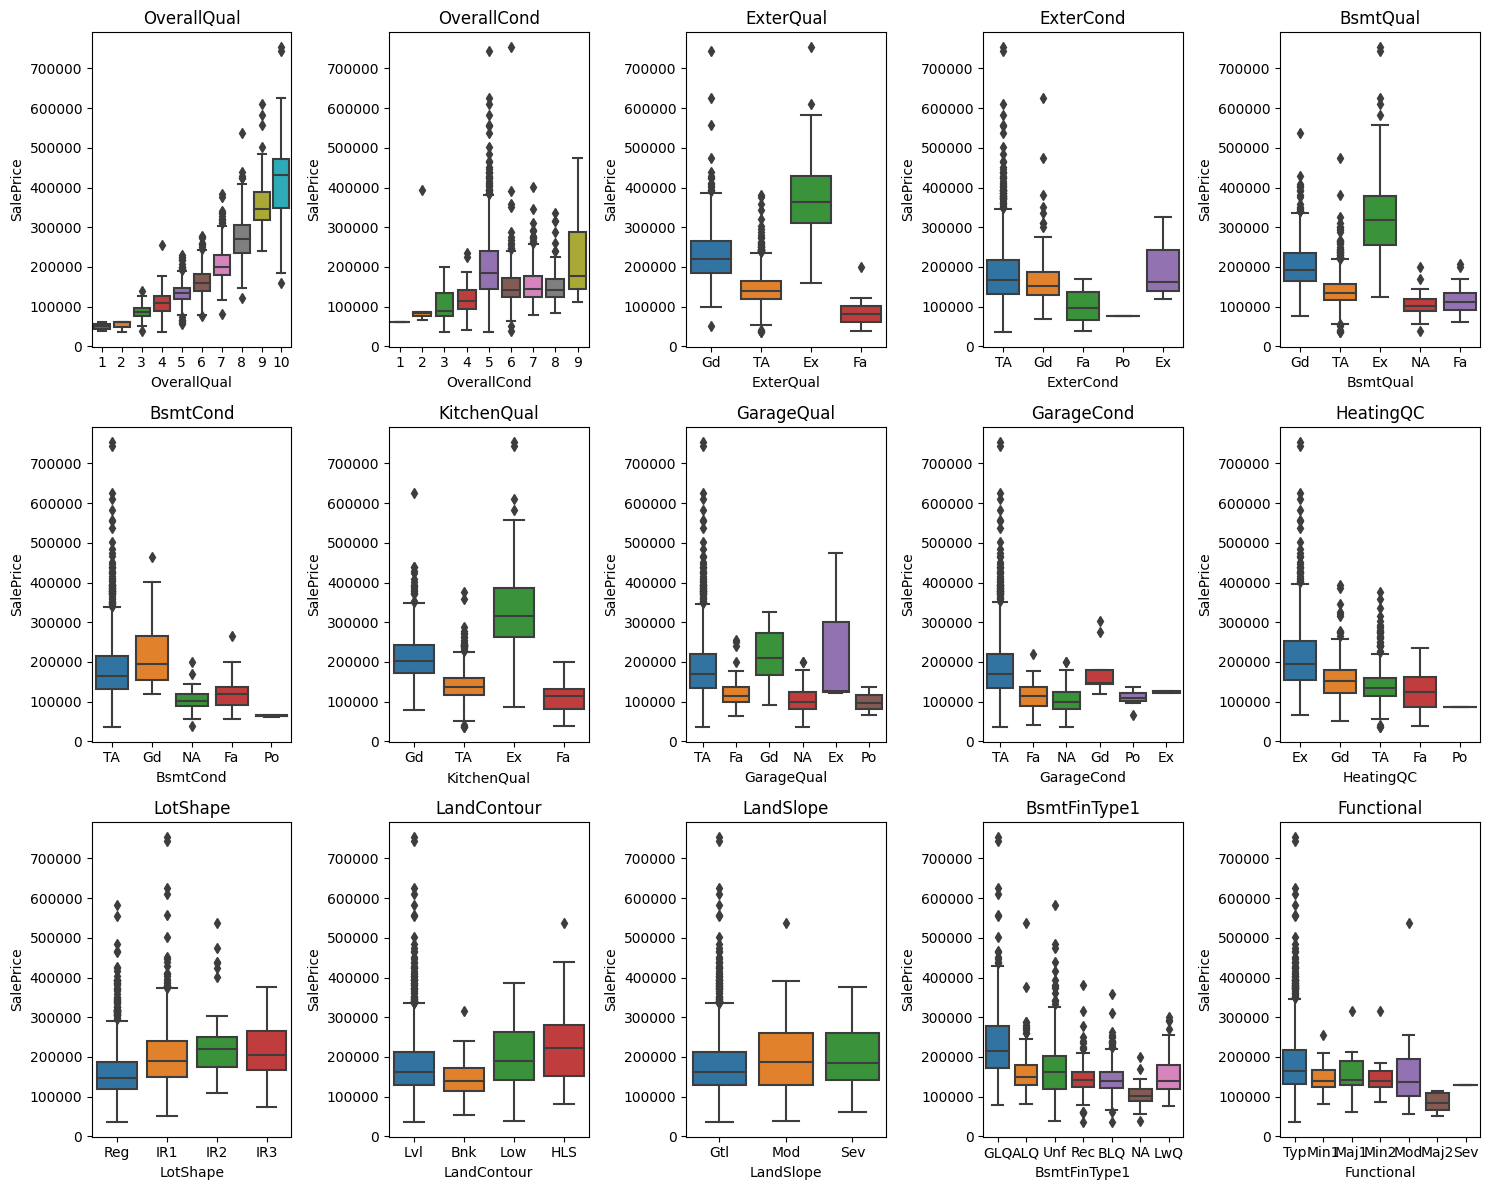

In [18]:
plots_per_row = 5
num_rows = (len(ordinal_cols) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))

axes = axes.flatten()

new_df = train_df
for i, col in enumerate(ordinal_cols):
    new_df[col].fillna('NA', inplace= True)
    sns.boxplot(x = col, y = 'SalePrice', data = new_df, ax = axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_mappings = {
    'OverallQual': [i for i in range(1,11)],
    'OverallCond': [i for i in range(1,11)],
    'ExterQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'ExterCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'BsmtCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'KitchenQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageQual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'GarageCond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'HeatingQC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
}

ordinal_cols = list(ordinal_mappings.keys())
non_ordinal_cols = [col for col in train_df.columns if col not in ordinal_cols]
test_non_ordinal_cols = [col for col in test_df.columns if col not in ordinal_cols]

encoder = OrdinalEncoder(categories=[ordinal_mappings[col] for col in ordinal_cols], handle_unknown = 'use_encoded_value', unknown_value = np.nan)

train_df_ordinal = pd.DataFrame(
    encoder.fit_transform(train_df[ordinal_cols]),
    columns=ordinal_cols
)

test_df_ordinal = pd.DataFrame(
    encoder.transform(test_df[ordinal_cols]),
    columns=ordinal_cols
)

train_df_enc = pd.concat([train_df_ordinal, train_df[non_ordinal_cols].reset_index(drop=True)], axis=1)
test_df_enc = pd.concat([test_df_ordinal, test_df[test_non_ordinal_cols].reset_index(drop=True)], axis=1)

X_train = train_df_enc.drop(columns = ['SalePrice', 'logSalePrice'])
y_train = train_df_enc['logSalePrice']

X_test = test_df_enc

The chosen encoded ordinal features seem suited for linear regression now:

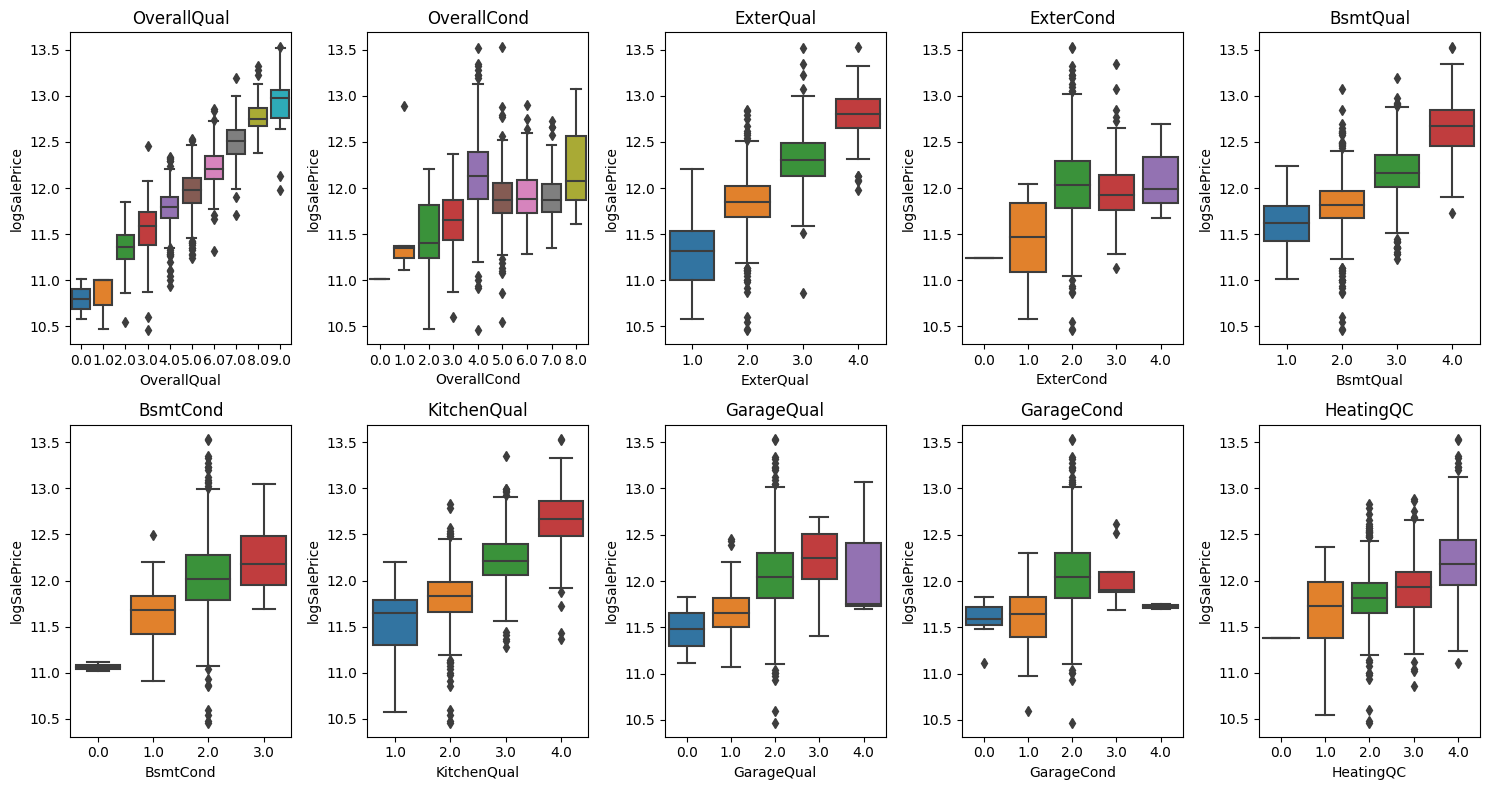

In [20]:
plots_per_row = 5
num_rows = (len(ordinal_cols) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))

axes = axes.flatten()

train_df_enc
for i, col in enumerate(ordinal_cols):
    train_df_enc[col].fillna('NA', inplace= True)
    sns.boxplot(x = col, y = 'logSalePrice', data = train_df_enc[~(train_df_enc[col] == 'NA')], ax = axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Categorical Features

In [21]:
remaining_features = list(set(train_df.columns).difference(area_feats).difference(ordinal_cols).difference({'SalePrice', 'logSalePrice'}))
train_df[remaining_features].dtypes

MoSold             int64
LotConfig         object
KitchenAbvGr       int64
YearBuilt          int64
RoofMatl          object
Utilities         object
FullBath           int64
HalfBath           int64
RoofStyle         object
Condition2        object
FireplaceQu       object
Heating           object
Fireplaces         int64
GarageCars         int64
DateSoldMos        int64
LandContour       object
MiscVal            int64
HouseStyle        object
GarageFinish      object
Electrical        object
MSZoning          object
BedroomAbvGr       int64
Condition1        object
TotRmsAbvGrd       int64
YearRemodAdd       int64
BsmtFullBath       int64
GarageYrBlt      float64
LotShape          object
BsmtFinType1      object
GarageType        object
SaleType          object
PavedDrive        object
3SsnPorch          int64
Functional        object
MasVnrType        object
BsmtFinType2      object
YrSold             int64
PoolQC            object
MiscFeature       object
BldgType          object


In [22]:
int_cols = train_df[remaining_features].select_dtypes(include = ['int64', 'float64']).columns
train_df[int_cols] = train_df[int_cols].astype('object')
train_df[remaining_features].dtypes

MoSold           object
LotConfig        object
KitchenAbvGr     object
YearBuilt        object
RoofMatl         object
Utilities        object
FullBath         object
HalfBath         object
RoofStyle        object
Condition2       object
FireplaceQu      object
Heating          object
Fireplaces       object
GarageCars       object
DateSoldMos      object
LandContour      object
MiscVal          object
HouseStyle       object
GarageFinish     object
Electrical       object
MSZoning         object
BedroomAbvGr     object
Condition1       object
TotRmsAbvGrd     object
YearRemodAdd     object
BsmtFullBath     object
GarageYrBlt      object
LotShape         object
BsmtFinType1     object
GarageType       object
SaleType         object
PavedDrive       object
3SsnPorch        object
Functional       object
MasVnrType       object
BsmtFinType2     object
YrSold           object
PoolQC           object
MiscFeature      object
BldgType         object
Alley            object
Street          

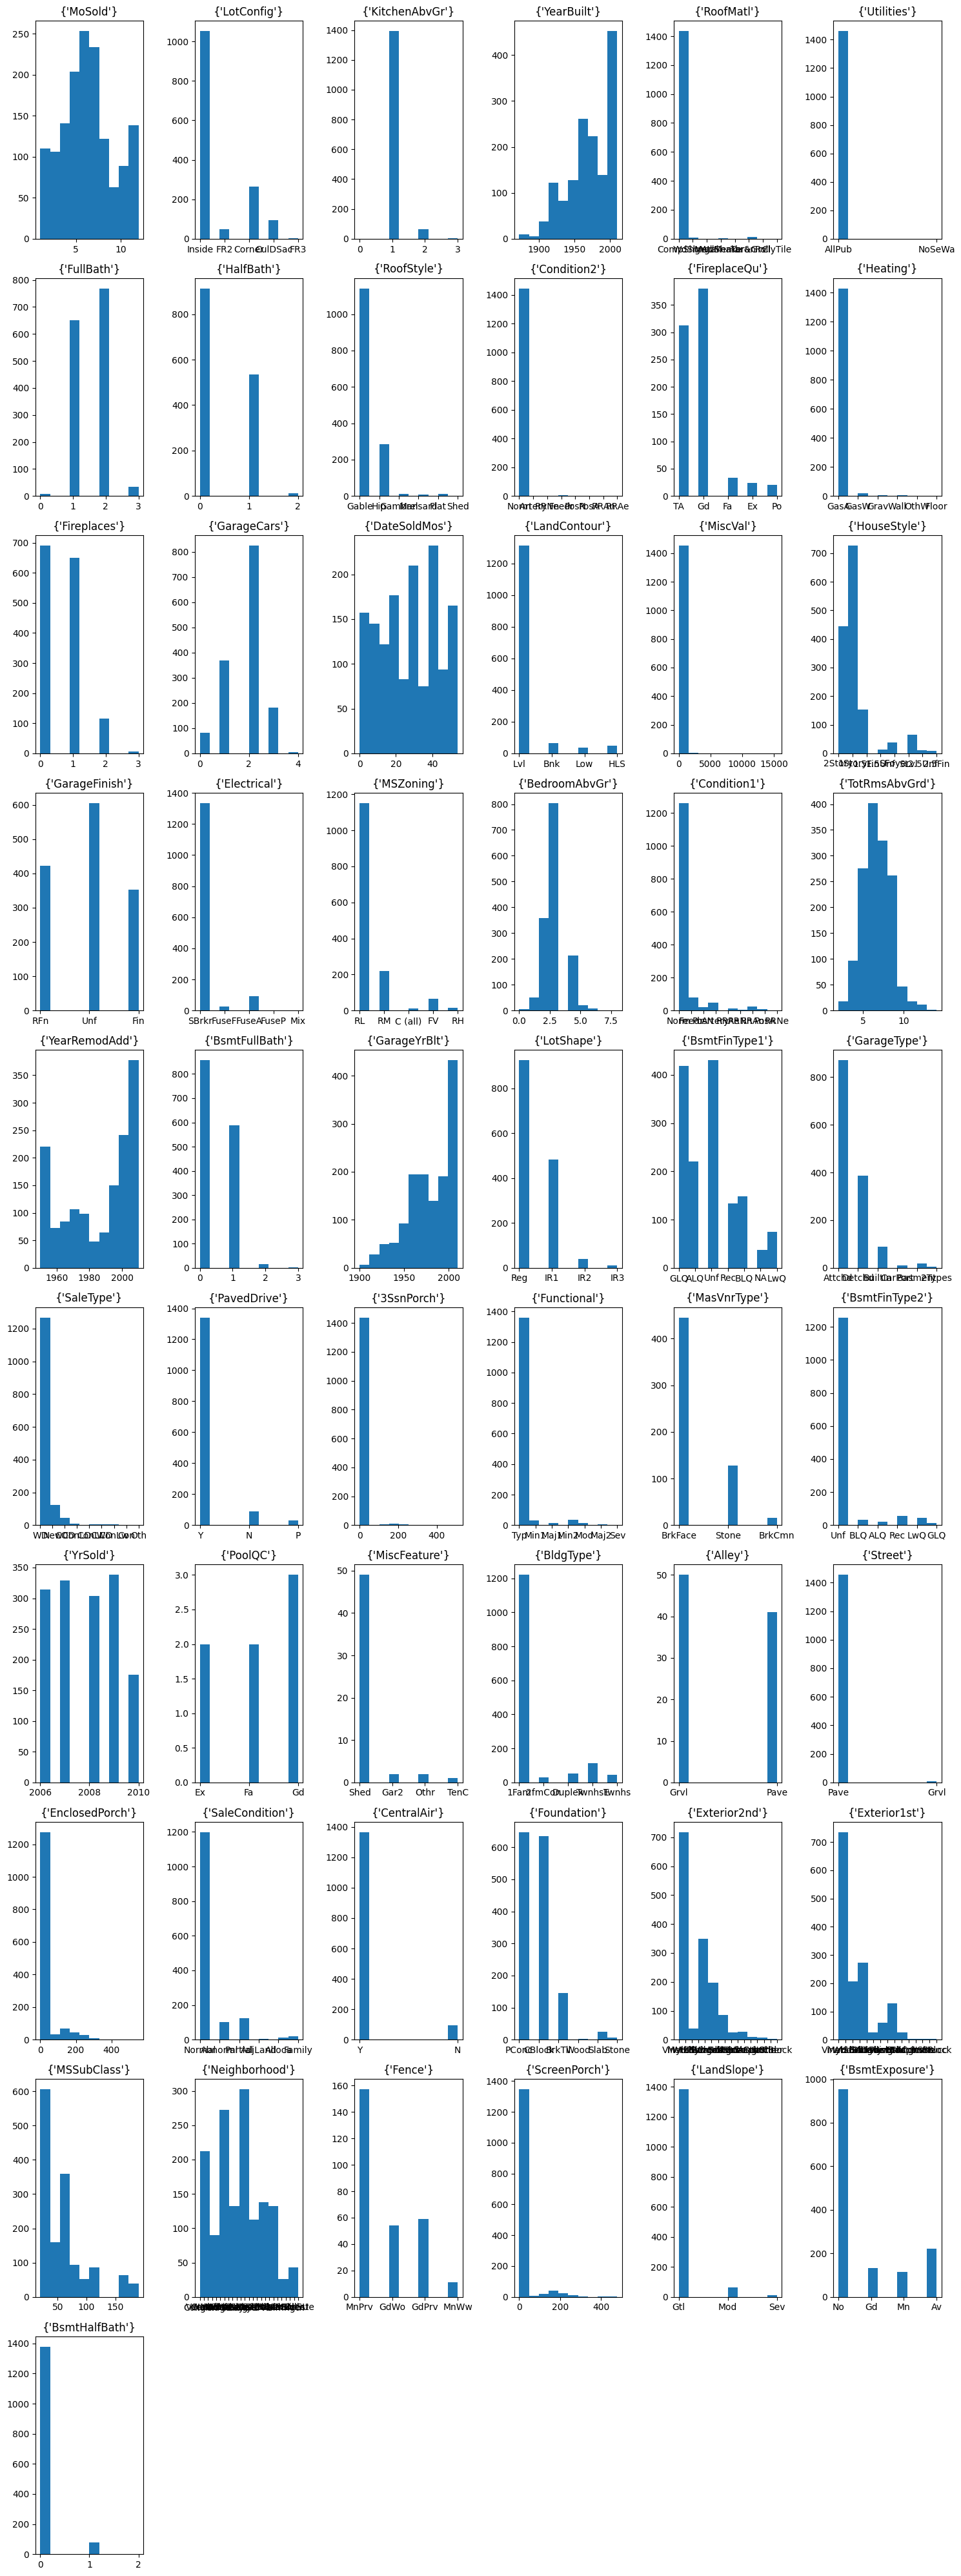

In [23]:
plots_per_row = 6
num_rows = (len(remaining_features) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))

axes = axes.flatten()

for i, col in enumerate(remaining_features):
    new_col = train_df[col].dropna()
    axes[i].hist(new_col)
    axes[i].set_title({col})

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

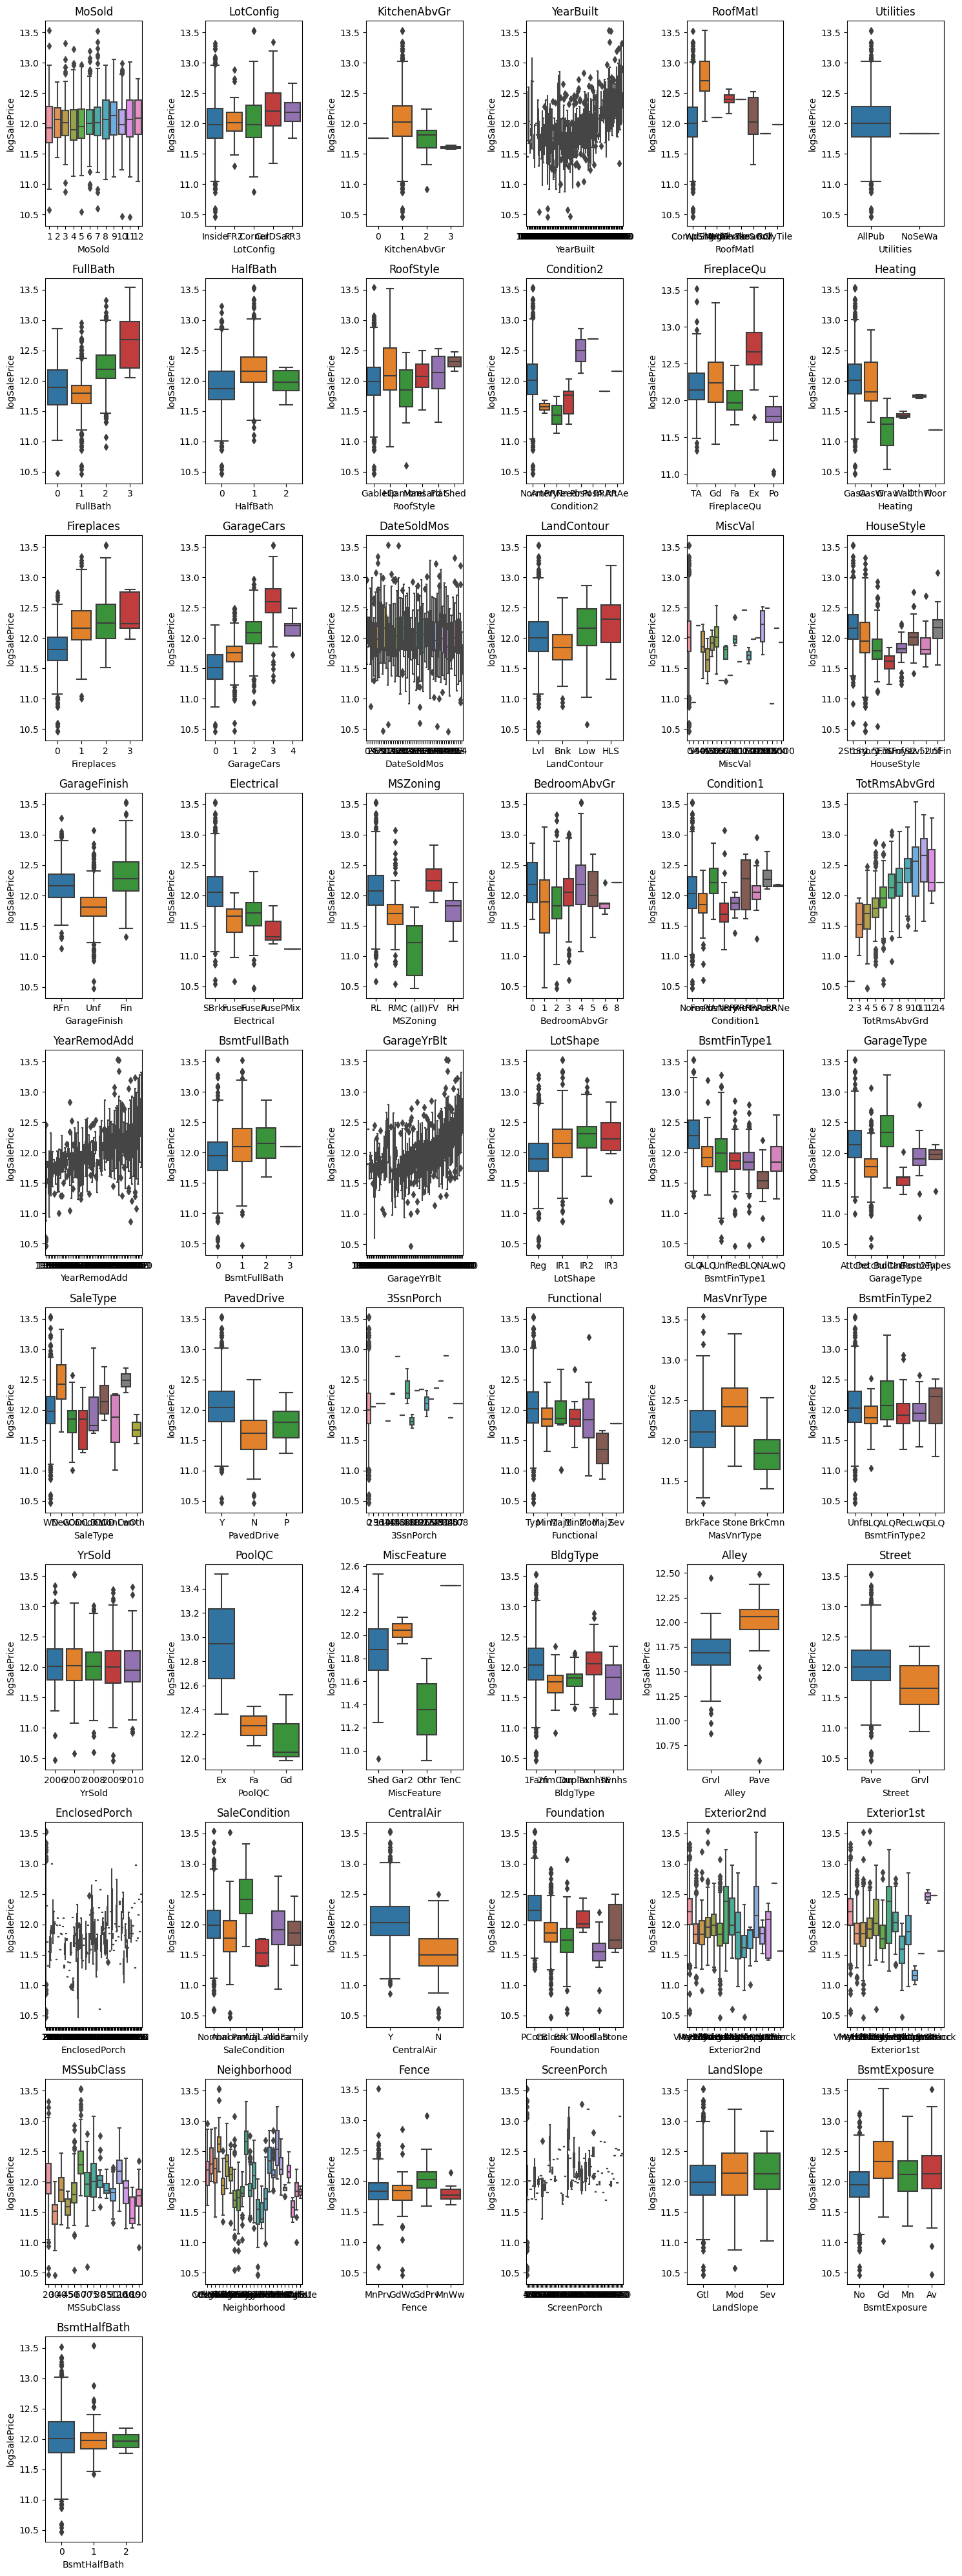

In [24]:
plots_per_row = 6
num_rows = (len(remaining_features) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))

axes = axes.flatten()

for i, col in enumerate(remaining_features):
    sns.boxplot(x = col, y = 'logSalePrice', data = train_df[~(train_df[col] == None)], ax = axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

This suggests some previously unconsidered features may be suited for linear regression. We add these as "other_cols" in the next section.

In [25]:
remaining_percentage_nans = (train_df[remaining_features].isna()).mean() * 100
remaining_percentage_nans

MoSold            0.000000
LotConfig         0.000000
KitchenAbvGr      0.000000
YearBuilt         0.000000
RoofMatl          0.000000
Utilities         0.000000
FullBath          0.000000
HalfBath          0.000000
RoofStyle         0.000000
Condition2        0.000000
FireplaceQu      47.260274
Heating           0.000000
Fireplaces        0.000000
GarageCars        0.000000
DateSoldMos       0.000000
LandContour       0.000000
MiscVal           0.000000
HouseStyle        0.000000
GarageFinish      5.547945
Electrical        0.068493
MSZoning          0.000000
BedroomAbvGr      0.000000
Condition1        0.000000
TotRmsAbvGrd      0.000000
YearRemodAdd      0.000000
BsmtFullBath      0.000000
GarageYrBlt       5.547945
LotShape          0.000000
BsmtFinType1      0.000000
GarageType        5.547945
SaleType          0.000000
PavedDrive        0.000000
3SsnPorch         0.000000
Functional        0.000000
MasVnrType       59.726027
BsmtFinType2      2.602740
YrSold            0.000000
P

# Stage 1: Linear Models

## Preprocessing

In [26]:
other_cols = ['YearBuilt', 'GarageCars', 'TotRmsAbvGrd', 'BsmtFullBath', 'YearRemodAdd', 'FullBath', 'Fireplaces', 'BedroomAbvGr', 'KitchenAbvGr', 'HalfBath']

X_train_lin = X_train[ordinal_cols + area_feats + other_cols]
X_test_lin = X_test[ordinal_cols + area_feats + other_cols]
X_train_lin = X_train_lin.astype('float64')

X_train_lin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   OverallQual   1460 non-null   float64
 1   OverallCond   1460 non-null   float64
 2   ExterQual     1460 non-null   float64
 3   ExterCond     1460 non-null   float64
 4   BsmtQual      1423 non-null   float64
 5   BsmtCond      1423 non-null   float64
 6   KitchenQual   1460 non-null   float64
 7   GarageQual    1379 non-null   float64
 8   GarageCond    1379 non-null   float64
 9   HeatingQC     1460 non-null   float64
 10  LotArea       1460 non-null   float64
 11  MasVnrArea    1452 non-null   float64
 12  BsmtFinSF1    1460 non-null   float64
 13  BsmtFinSF2    1460 non-null   float64
 14  BsmtUnfSF     1460 non-null   float64
 15  TotalBsmtSF   1460 non-null   float64
 16  1stFlrSF      1460 non-null   float64
 17  2ndFlrSF      1460 non-null   float64
 18  LowQualFinSF  1460 non-null 

In [27]:
area_percentage_nans = (X_train_lin[area_feats].isna()).mean() * 100
print("Train area percentage nans")
area_percentage_nans

Train area percentage nans


LotArea          0.000000
MasVnrArea       0.547945
BsmtFinSF1       0.000000
BsmtFinSF2       0.000000
BsmtUnfSF        0.000000
TotalBsmtSF      0.000000
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
GarageArea       0.000000
WoodDeckSF       0.000000
OpenPorchSF      0.000000
PoolArea         0.000000
LotFrontage     17.739726
dtype: float64

In [29]:
area_percentage_zeros = (X_train_lin[area_feats].isin([0])).mean() * 100
print("Train area percentage zeros")
area_percentage_zeros

Train area percentage zeros


LotArea          0.000000
MasVnrArea      58.972603
BsmtFinSF1      31.986301
BsmtFinSF2      88.561644
BsmtUnfSF        8.082192
TotalBsmtSF      2.534247
1stFlrSF         0.000000
2ndFlrSF        56.780822
LowQualFinSF    98.219178
GrLivArea        0.000000
GarageArea       5.547945
WoodDeckSF      52.123288
OpenPorchSF     44.931507
PoolArea        99.520548
LotFrontage      0.000000
dtype: float64

In [30]:
test_area_percentage_nan = (X_test_lin[area_feats].isna()).mean() * 100
print("Test area percentage nan")
test_area_percentage_nan

Test area percentage nan


LotArea          0.000000
MasVnrArea       1.028101
BsmtFinSF1       0.068540
BsmtFinSF2       0.068540
BsmtUnfSF        0.068540
TotalBsmtSF      0.068540
1stFlrSF         0.000000
2ndFlrSF         0.000000
LowQualFinSF     0.000000
GrLivArea        0.000000
GarageArea       0.068540
WoodDeckSF       0.000000
OpenPorchSF      0.000000
PoolArea         0.000000
LotFrontage     15.558602
dtype: float64

In [31]:
test_area_percentage_zeros = (X_test_lin[area_feats].isin([0])).mean() * 100
print("Test area percentage zeros")
test_area_percentage_zeros

Test area percentage zeros


LotArea          0.000000
MasVnrArea      60.109664
BsmtFinSF1      31.665524
BsmtFinSF2      87.594243
BsmtUnfSF        8.430432
TotalBsmtSF      2.810144
1stFlrSF         0.000000
2ndFlrSF        57.505141
LowQualFinSF    99.040439
GrLivArea        0.000000
GarageArea       5.209047
WoodDeckSF      52.227553
OpenPorchSF     44.002742
PoolArea        99.588759
LotFrontage      0.000000
dtype: float64

In [32]:
ord_percentage_nans = (X_train_lin[ordinal_cols].isna()).mean() * 100
print("Train ordinal percentage nan")
ord_percentage_nans

Train ordinal percentage nan


OverallQual    0.000000
OverallCond    0.000000
ExterQual      0.000000
ExterCond      0.000000
BsmtQual       2.534247
BsmtCond       2.534247
KitchenQual    0.000000
GarageQual     5.547945
GarageCond     5.547945
HeatingQC      0.000000
dtype: float64

In [33]:
test_ord_percentage_nans = (X_test_lin[ordinal_cols].isna()).mean() * 100
print("Test ordinal percentage nan")
test_ord_percentage_nans

Test ordinal percentage nan


OverallQual    0.000000
OverallCond    0.000000
ExterQual      0.000000
ExterCond      0.000000
BsmtQual       3.015764
BsmtCond       3.084304
KitchenQual    0.068540
GarageQual     5.346127
GarageCond     5.346127
HeatingQC      0.000000
dtype: float64

In [34]:
other_percentage_nans = (X_train_lin[other_cols].isna()).mean() * 100
print("Train other percentage nan")
other_percentage_nans

Train other percentage nan


YearBuilt       0.0
GarageCars      0.0
TotRmsAbvGrd    0.0
BsmtFullBath    0.0
YearRemodAdd    0.0
FullBath        0.0
Fireplaces      0.0
BedroomAbvGr    0.0
KitchenAbvGr    0.0
HalfBath        0.0
dtype: float64

In [35]:
test_other_percentage_nans = (X_test_lin[other_cols].isna()).mean() * 100
print("Test other percentage nan")
test_other_percentage_nans

Test other percentage nan


YearBuilt       0.00000
GarageCars      0.06854
TotRmsAbvGrd    0.00000
BsmtFullBath    0.13708
YearRemodAdd    0.00000
FullBath        0.00000
Fireplaces      0.00000
BedroomAbvGr    0.00000
KitchenAbvGr    0.00000
HalfBath        0.00000
dtype: float64

We see that 2.53% and 5.55% of points don't have a basement or a garage, respectively. We will drop these points for now, along with the columns with >10% missing data.

In [28]:
drop_cols = ['MasVnrArea', 'PoolArea', 'BsmtFinSF2', 'LowQualFinSF']
area_cols = list(set(area_feats).difference(set(drop_cols)))

X_train_lin.drop(columns = drop_cols, inplace= True)
X_test_lin.drop(columns = drop_cols, inplace = True)

#selected_rows = (X_train_lin[area_cols] != 0).all(axis=1) & X_train_lin[area_cols].notna().all(axis=1)

#X_train_lin = X_train_lin[selected_rows]
#y_train_lin = y_train[selected_rows]
X_train_lin.describe()

OverallQual  OverallCond   ExterQual    ExterCond     BsmtQual  \
count  1460.000000  1460.000000  1460.00000  1460.000000  1423.000000   
mean      5.099315     4.575342     2.39589     2.083562     2.579761   
std       1.382997     1.112799     0.57428     0.351054     0.680602   
min       0.000000     0.000000     1.00000     0.000000     1.000000   
25%       4.000000     4.000000     2.00000     2.000000     2.000000   
50%       5.000000     4.000000     2.00000     2.000000     3.000000   
75%       6.000000     5.000000     3.00000     2.000000     3.000000   
max       9.000000     8.000000     4.00000     4.000000     4.000000   

          BsmtCond  KitchenQual   GarageQual   GarageCond    HeatingQC  ...  \
count  1423.000000  1460.000000  1379.000000  1379.000000  1460.000000  ...   
mean      2.011244     2.511644     1.975344     1.973894     3.145205  ...   
std       0.287846     0.663760     0.248598     0.239527     0.959501  ...   
min       0.000000     1.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000     2.000000     2.000000     2.000000     2.000000  ...   
50%       2.000000     2.000000     2.000000     2.000000     4.000000  ...   
75%       2.000000     3.000000     2.000000     2.000000     4.000000  ...   
max       3.000000     4.000000     4.000000     4.000000     4.000000  ...   

         YearBuilt   GarageCars  TotRmsAbvGrd  BsmtFullBath  YearRemodAdd  \
count  1460.000000  1460.000000   1460.000000   1460.000000   1460.000000   
mean   1971.267808     1.767123      6.517808      0.425342   1984.865753   
std      30.202904     0.747315      1.625393      0.518911     20.645407   
min    1872.000000     0.000000      2.000000      0.000000   1950.000000   
25%    1954.000000     1.000000      5.000000      0.000000   1967.000000   
50%    1973.000000     2.000000      6.000000      0.000000   1994.000000   
75%    2000.000000     2.000000      7.000000      1.000000   2004.000000   
max    2010.000000     4.000000     14.000000      3.000000   2010.000000   

          FullBath   Fireplaces  BedroomAbvGr  KitchenAbvGr     HalfBath  
count  1460.000000  1460.000000   1460.000000   1460.000000  1460.000000  
mean      1.565068     0.613014      2.866438      1.046575     0.382877  
std       0.550916     0.644666      0.815778      0.220338     0.502885  
min       0.000000     0.000000      0.000000      0.000000     0.000000  
25%       1.000000     0.000000      2.000000      1.000000     0.000000  
50%       2.000000     1.000000      3.000000      1.000000     0.000000  
75%       2.000000     1.000000      3.000000      1.000000     1.000000  
max       3.000000     3.000000      8.000000      3.000000     2.000000  

[8 rows x 31 columns]

Add binary features for area features with signifcant number of zeros.

In [29]:
# For the training set
X_train_lin['HasPool'] = (train_df['PoolArea'] > 0).astype(int)
X_train_lin['Has2ndFloor'] = (train_df['2ndFlrSF'] > 0).astype(int)
X_train_lin['HasWoodDeck'] = (train_df['WoodDeckSF'] > 0).astype(int)
X_train_lin['HasMasVnr'] = (train_df['MasVnrArea'] > 0).astype(int)
X_train_lin['HasBsmt'] = (train_df['BsmtFinSF1'] > 0).astype(int)
X_train_lin['HasOpenPorch'] = (train_df['OpenPorchSF'] > 0).astype(int)
X_train_lin['WasRemod'] = (train_df['YearRemodAdd'] > train_df['YearBuilt']).astype(int)

# For the test set
X_test_lin['HasPool'] = (test_df['PoolArea'] > 0).astype(int)
X_test_lin['Has2ndFloor'] = (test_df['2ndFlrSF'] > 0).astype(int)
X_test_lin['HasWoodDeck'] = (test_df['WoodDeckSF'] > 0).astype(int)
X_test_lin['HasMasVnr'] = (test_df['MasVnrArea'] > 0).astype(int)
X_test_lin['HasBsmt'] = (test_df['BsmtFinSF1'] > 0).astype(int)
X_test_lin['HasOpenPorch'] = (test_df['OpenPorchSF'] > 0).astype(int)
X_test_lin['WasRemod'] = (test_df['YearRemodAdd'] > test_df['YearBuilt']).astype(int)

Lastly we apply a log transformation to the remaining area features:

In [30]:
X_train_lin[area_cols] = X_train_lin[area_cols].apply(lambda x: np.log(x + 1))
X_test_lin[area_cols] = X_test_lin[area_cols].apply(lambda x: np.log(x + 1))

The data is finally ready for linear models!

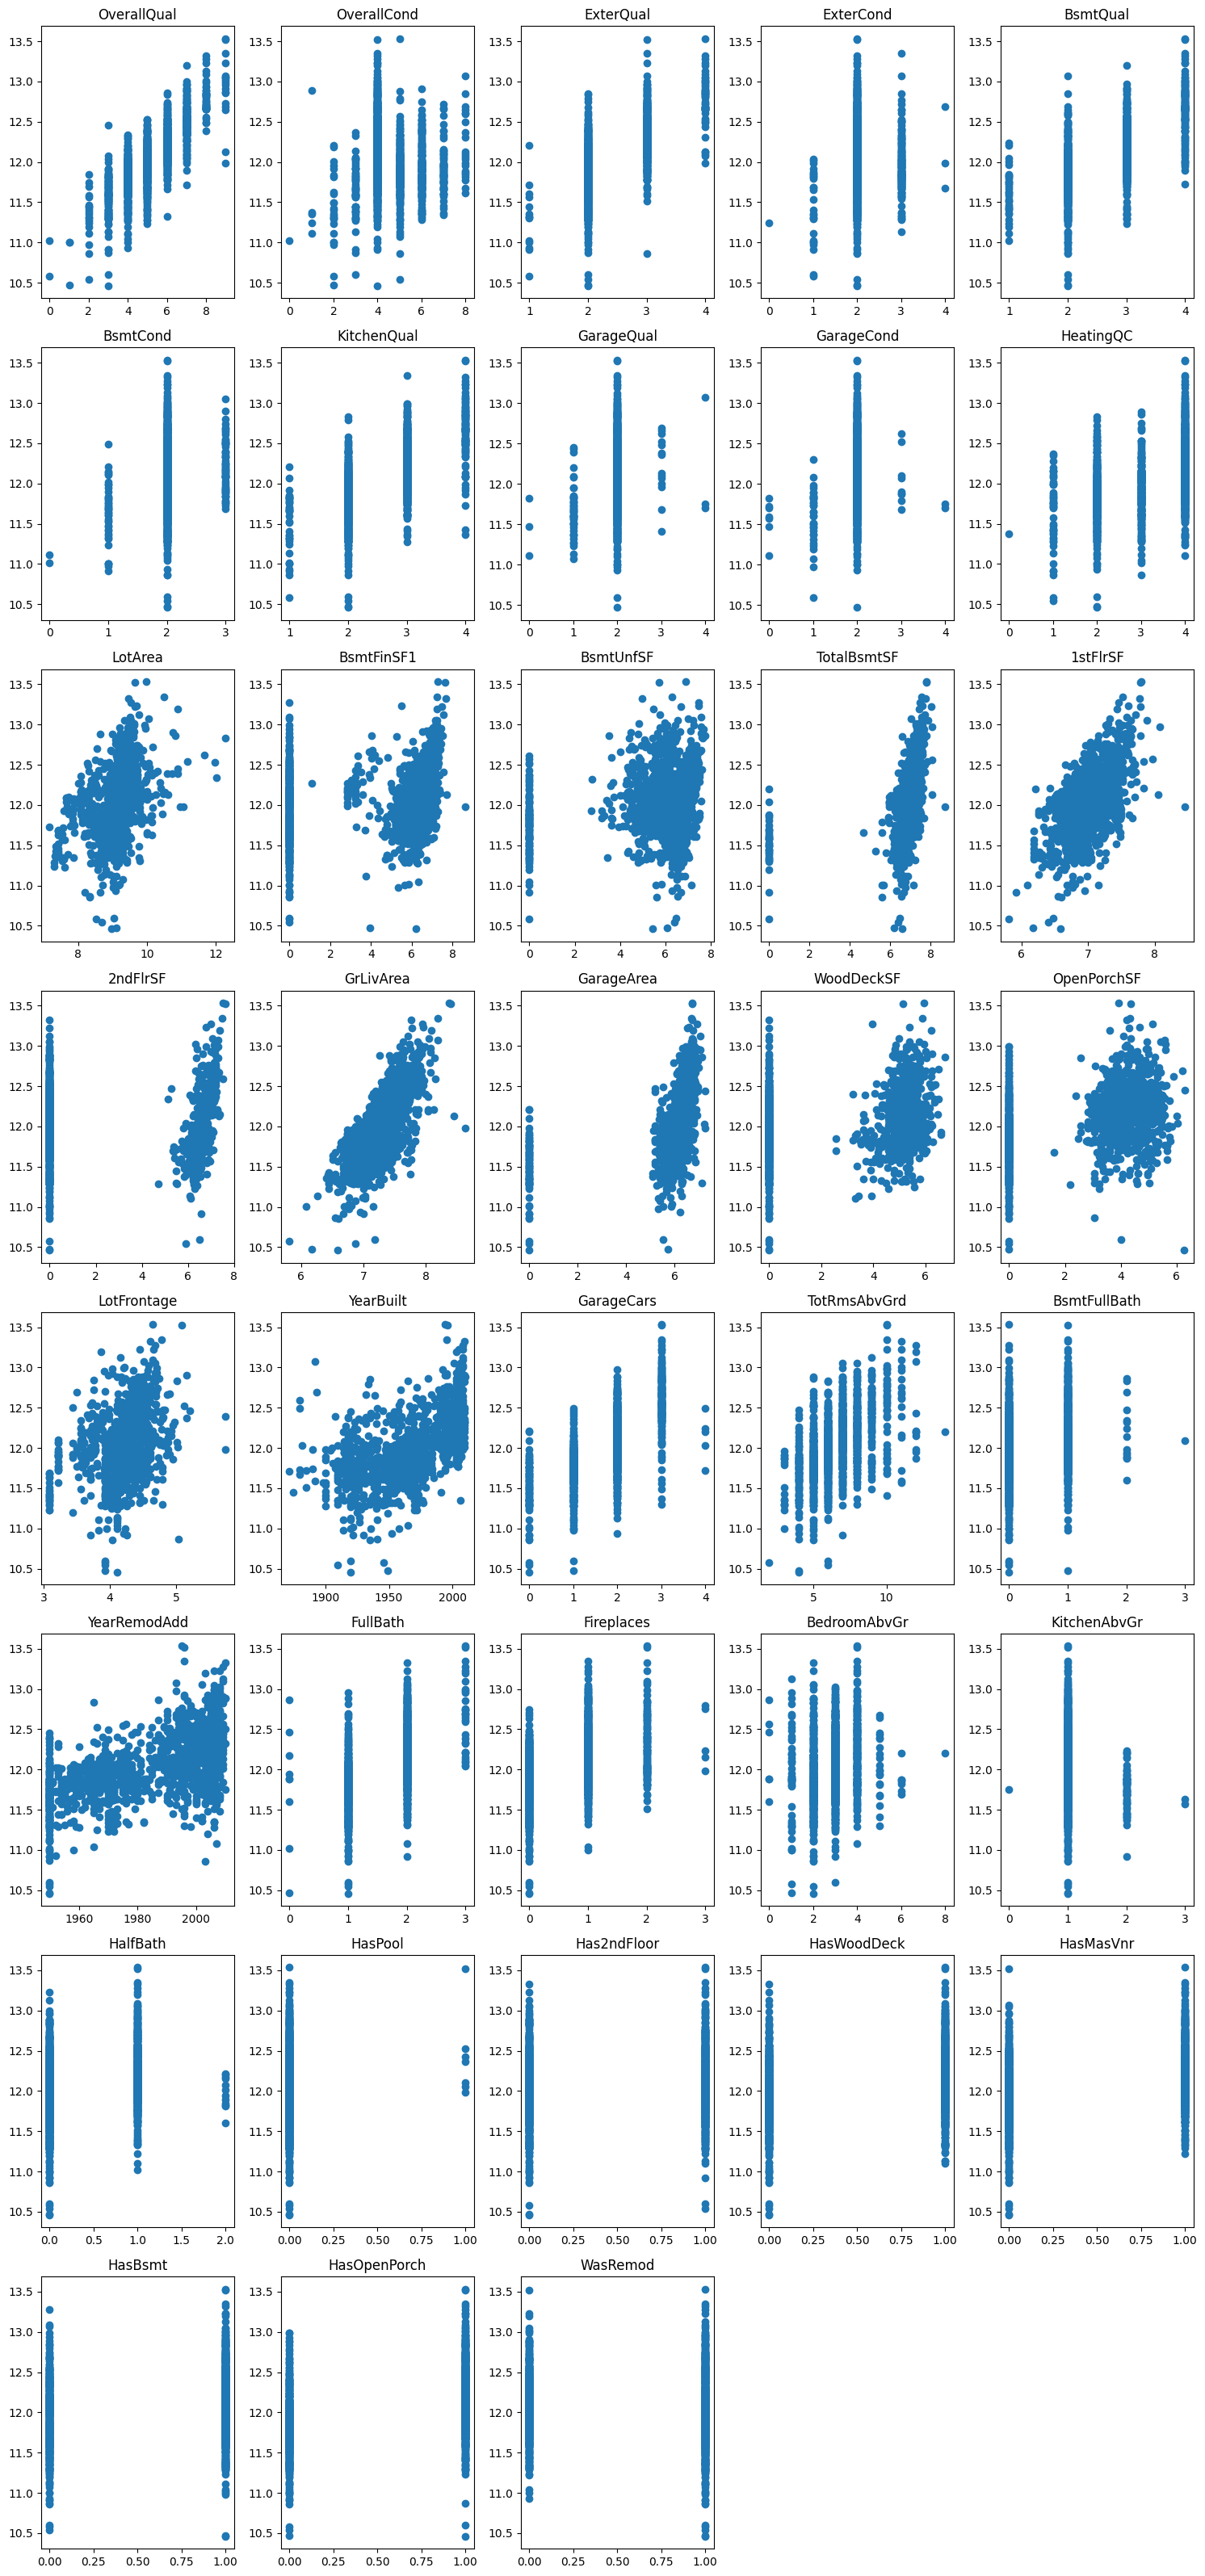

In [31]:
plots_per_row = 5
num_rows = (len(X_train_lin.columns) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))

axes = axes.flatten()

for i, col in enumerate(X_train_lin.columns):
    X_train_lin['logSalePrice'] = y_train
    axes[i].scatter(x = col, y = 'logSalePrice', data = X_train_lin)
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

X_train_lin.drop(columns = 'logSalePrice', inplace = True)
plt.tight_layout()
plt.show()

For area and 'HasX' features we fill nan with zeros, since nan likely indicates that the feature is absent, e.g. 'HasPool'. For the remaining features correspond to quality/condition we fill with median.

In [32]:
binary_cols = [col for col in X_train_lin.columns if 'Has' in col] + ['WasRemod']

for col in area_cols+binary_cols:
    X_train_lin[col].fillna(0, inplace = True)
    X_test_lin[col].fillna(0, inplace = True)
    
for col in [col for col in X_train_lin.columns if col not in area_cols+binary_cols+['logSalePrice']]:
    col_median = X_train_lin[col].median()
    X_train_lin[col].fillna(col_median, inplace = True)
    X_test_lin[col].fillna(col_median, inplace = True)  

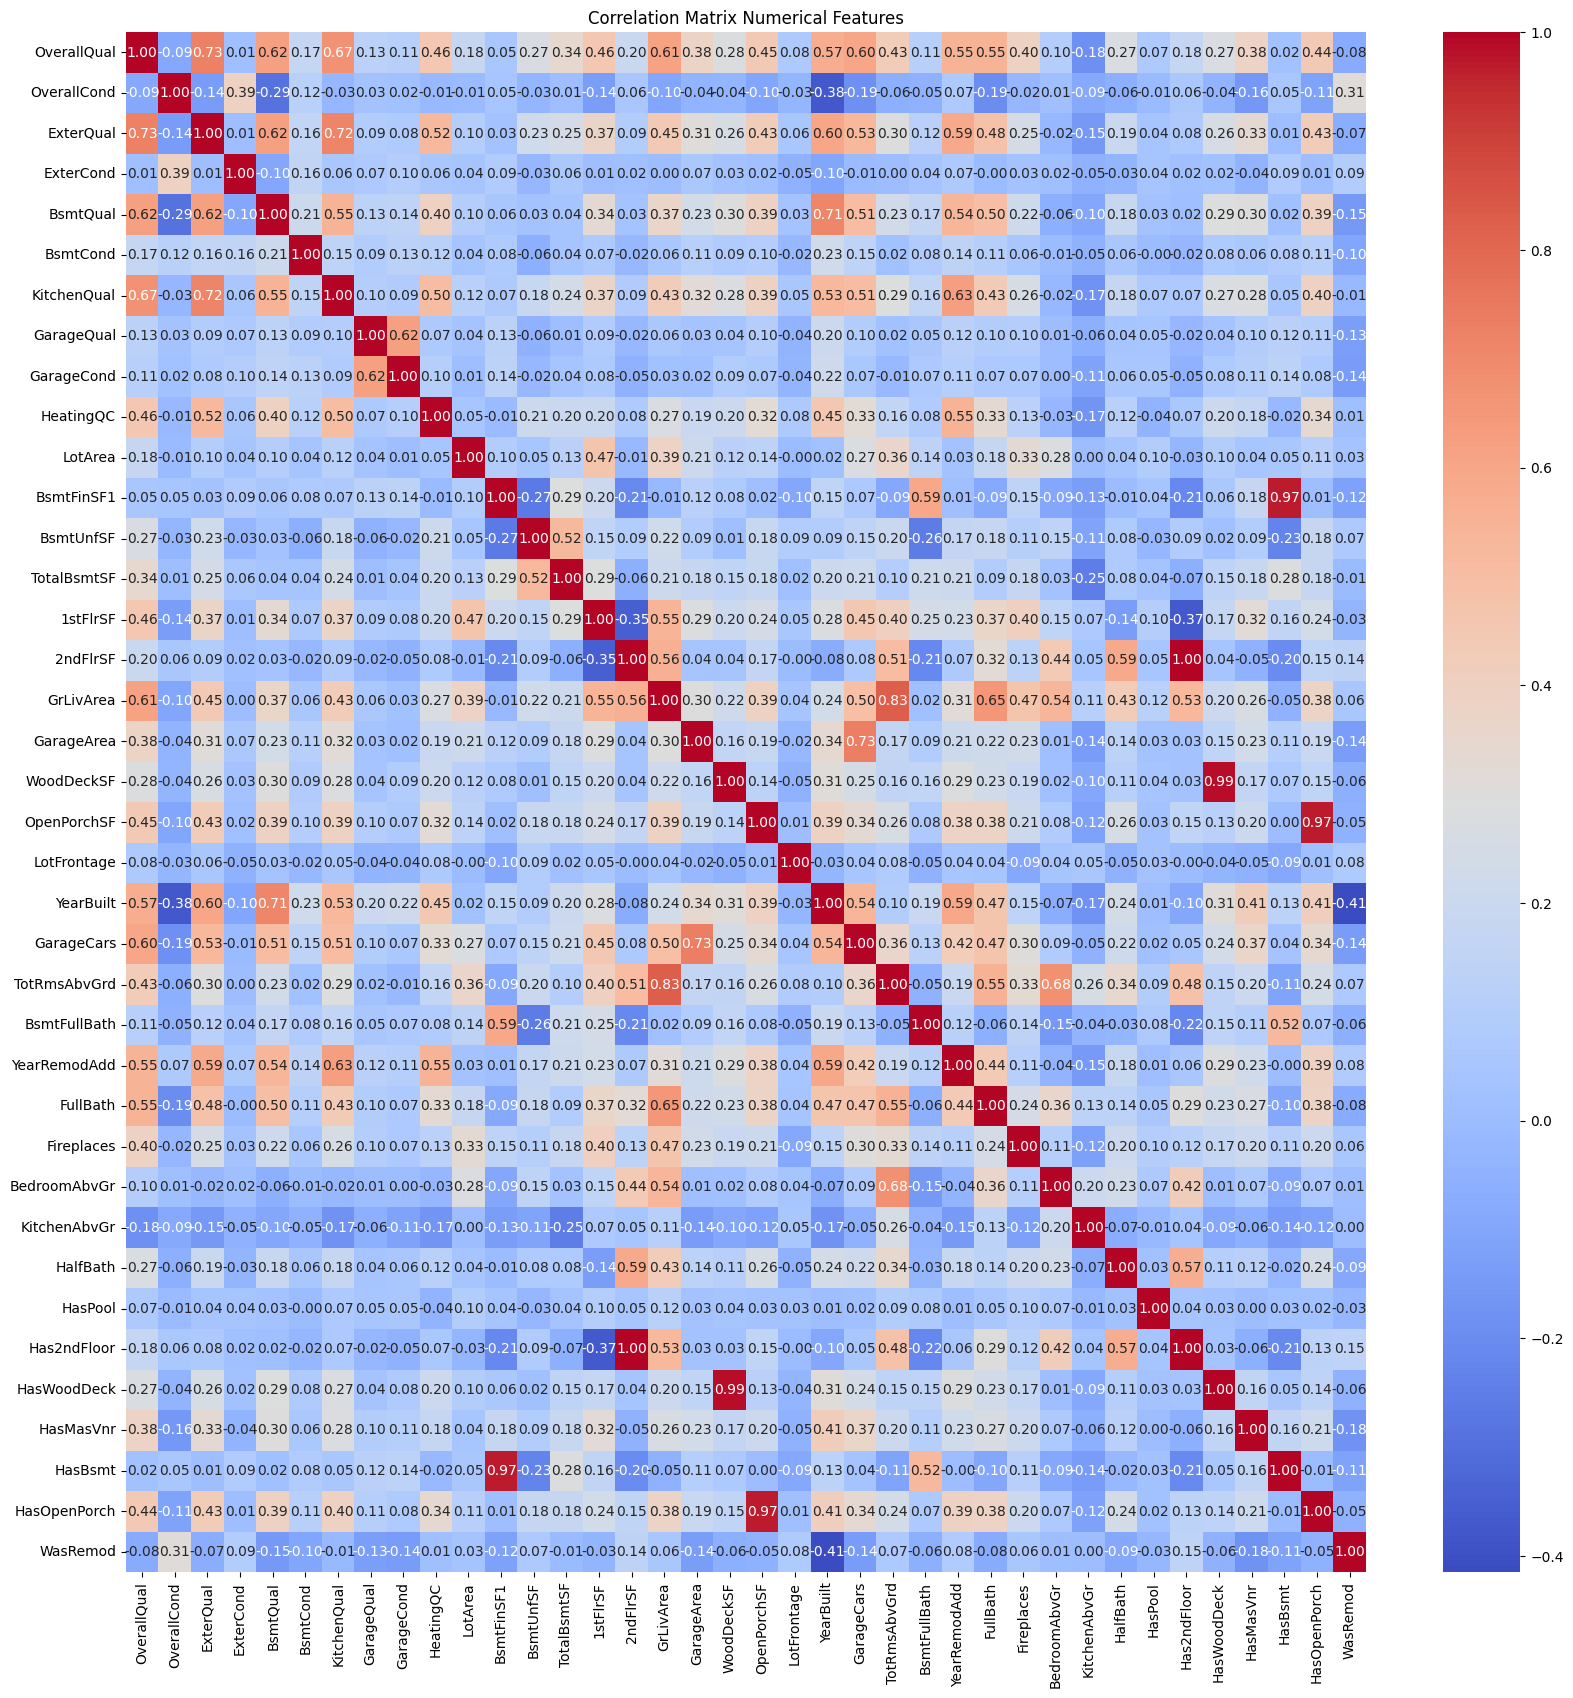

In [33]:
corr_matrix = X_train_lin.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Numerical Features')
plt.show()

## Ordinary Least Squares

In [34]:
from sklearn.linear_model import LinearRegression

ols_regressor = LinearRegression()
y_train_lin = train_df['logSalePrice']

ols_regressor.fit(X_train_lin, y_train_lin)
y_train_ols_pred = ols_regressor.predict(X_train_lin)

OLS with just the features above accounts for ~88% of the variance in the data.

In [35]:
from sklearn.metrics import r2_score, mean_squared_error

print(f"Root mean squared error: {np.sqrt(mean_squared_error(y_train_ols_pred, y_train_lin))}")
print(f"r2 score: {r2_score(y_train_ols_pred, y_train_lin)}")

Root mean squared error: 0.13146998106056745
r2 score: 0.878423149690647


In [36]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state = 777)

ols = LinearRegression()
ols_cv_score = np.mean(-cross_val_score(ols, X_train_lin, y=y_train_lin, scoring = 'neg_root_mean_squared_error', cv=kf, verbose=0))

print(f"OLS CV RMSE: {ols_cv_score}")

OLS CV RMSE: 0.13880228680306522


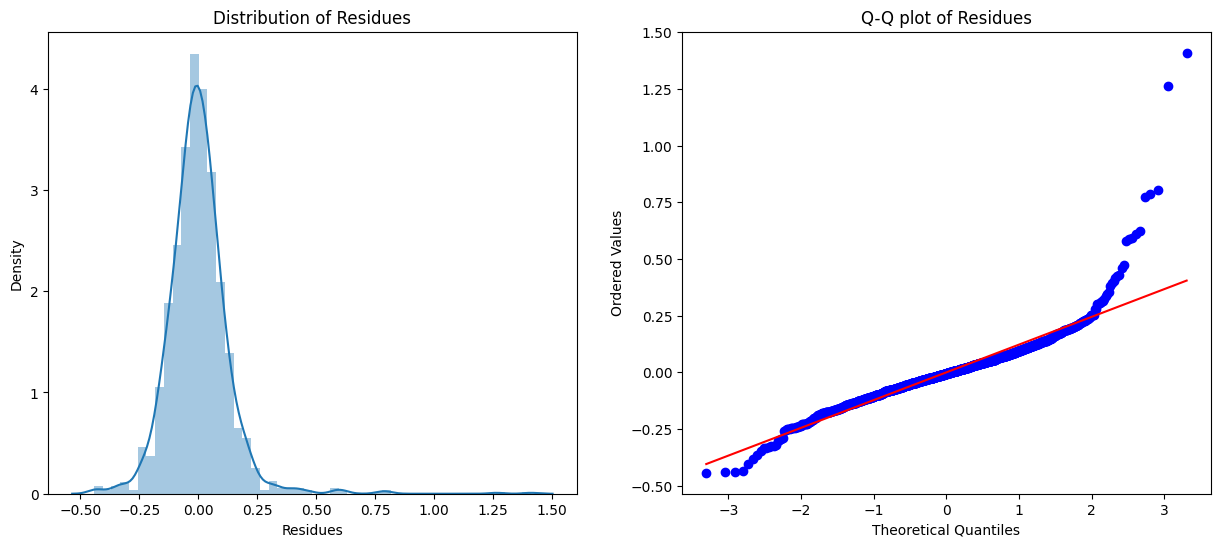

In [37]:
residues = y_train_ols_pred - y_train_lin

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(residues, ax = axes[0])
stats.probplot(residues, dist="norm", plot = axes[1])
axes[0].set_xlabel("Residues")
axes[0].set_title("Distribution of Residues")
axes[1].set_title(f'Q-Q plot of Residues')
axes[1].set_xlabel("Theoretical Quantiles")
plt.show()

The residues are almost normally distributed, with a fat tail on the right. Maybe regularization can fix this.

In [38]:
res_mean = residues.mean()
res_sample_var = residues.var()
print(res_mean, res_sample_var)

1.264133394614288e-15 0.017296202634198975


## Lasso

In [39]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def custom_cv(model, X, y, alphas, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state = 777)
    mean_errors = []
    best_coefs = []
    best_alpha = None
    best_error = np.inf

    for alpha in alphas:
        model.set_params(alpha=alpha)
        errors = []
        coefs = []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index, :], X[val_index, :]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            error = mean_squared_error(y_val, y_pred)
            errors.append(error)
            coefs.append(model.coef_)

        mean_errors.append(np.mean(errors))
        best_coefs.append(np.mean(coefs, axis=0))
        if np.mean(errors) < best_error:
            best_alpha = alpha
            best_error = np.mean(errors)

    return best_alpha, best_error, mean_errors, np.array(best_coefs)

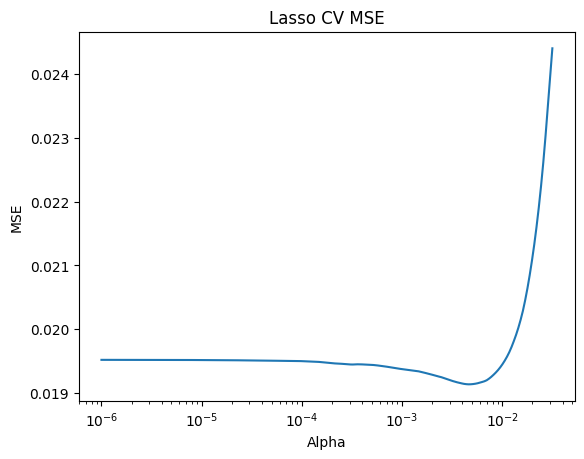

In [40]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

lasso = Lasso(max_iter = 10000)
lasso_alphas = np.logspace(-6, -1.5, 200)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lin)
X_test_scaled = scaler.transform(X_test_lin)

best_alpha_lasso, best_error_lasso, lasso_cv_errors, lasso_coefs = custom_cv(lasso, X_train_scaled, y_train_lin, lasso_alphas)

plt.plot(lasso_alphas, lasso_cv_errors)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Lasso CV MSE')
plt.show()

In [41]:
print(f"Best alpha Lasso: {best_alpha_lasso}")
print(f"Best RMSE Lasso: {np.sqrt(best_error_lasso)}")

Best alpha Lasso: 0.004605922041145108
Best RMSE Lasso: 0.13831778473535103


Notice that LotArea has quite some impact on the prediction, and that the non-normality (heavy right tail) of LotArea starting at 2 stdev away from the mean appears in the residues as well. Let's experimenting adding a feature to make up for this at the end.

In [42]:
best_lasso = Lasso(alpha = best_alpha_lasso, max_iter = 20000)

best_lasso.fit(X_train_scaled, y_train_lin)

y_train_lasso_pred = best_lasso.predict(X_train_scaled)
y_test_lasso = best_lasso.predict(X_test_scaled)

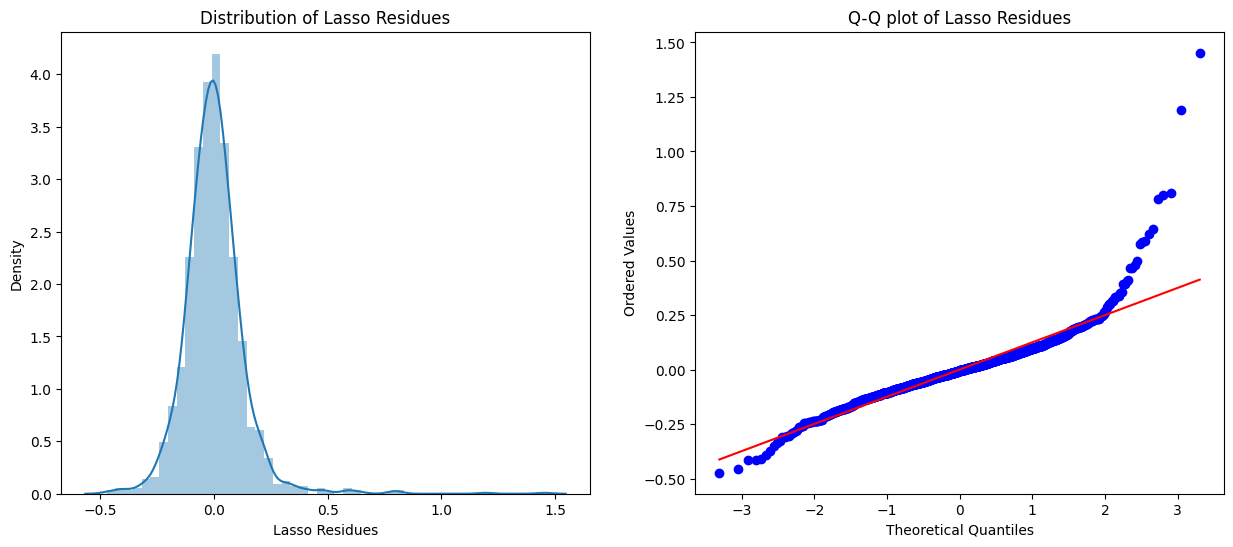

In [43]:
lasso_residues = y_train_lasso_pred - y_train_lin

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(lasso_residues, ax = axes[0])
stats.probplot(lasso_residues, dist="norm", plot = axes[1])
axes[0].set_xlabel("Lasso Residues")
axes[0].set_title("Distribution of Lasso Residues")
axes[1].set_title(f'Q-Q plot of Lasso Residues')
axes[1].set_xlabel("Theoretical Quantiles")
plt.show()

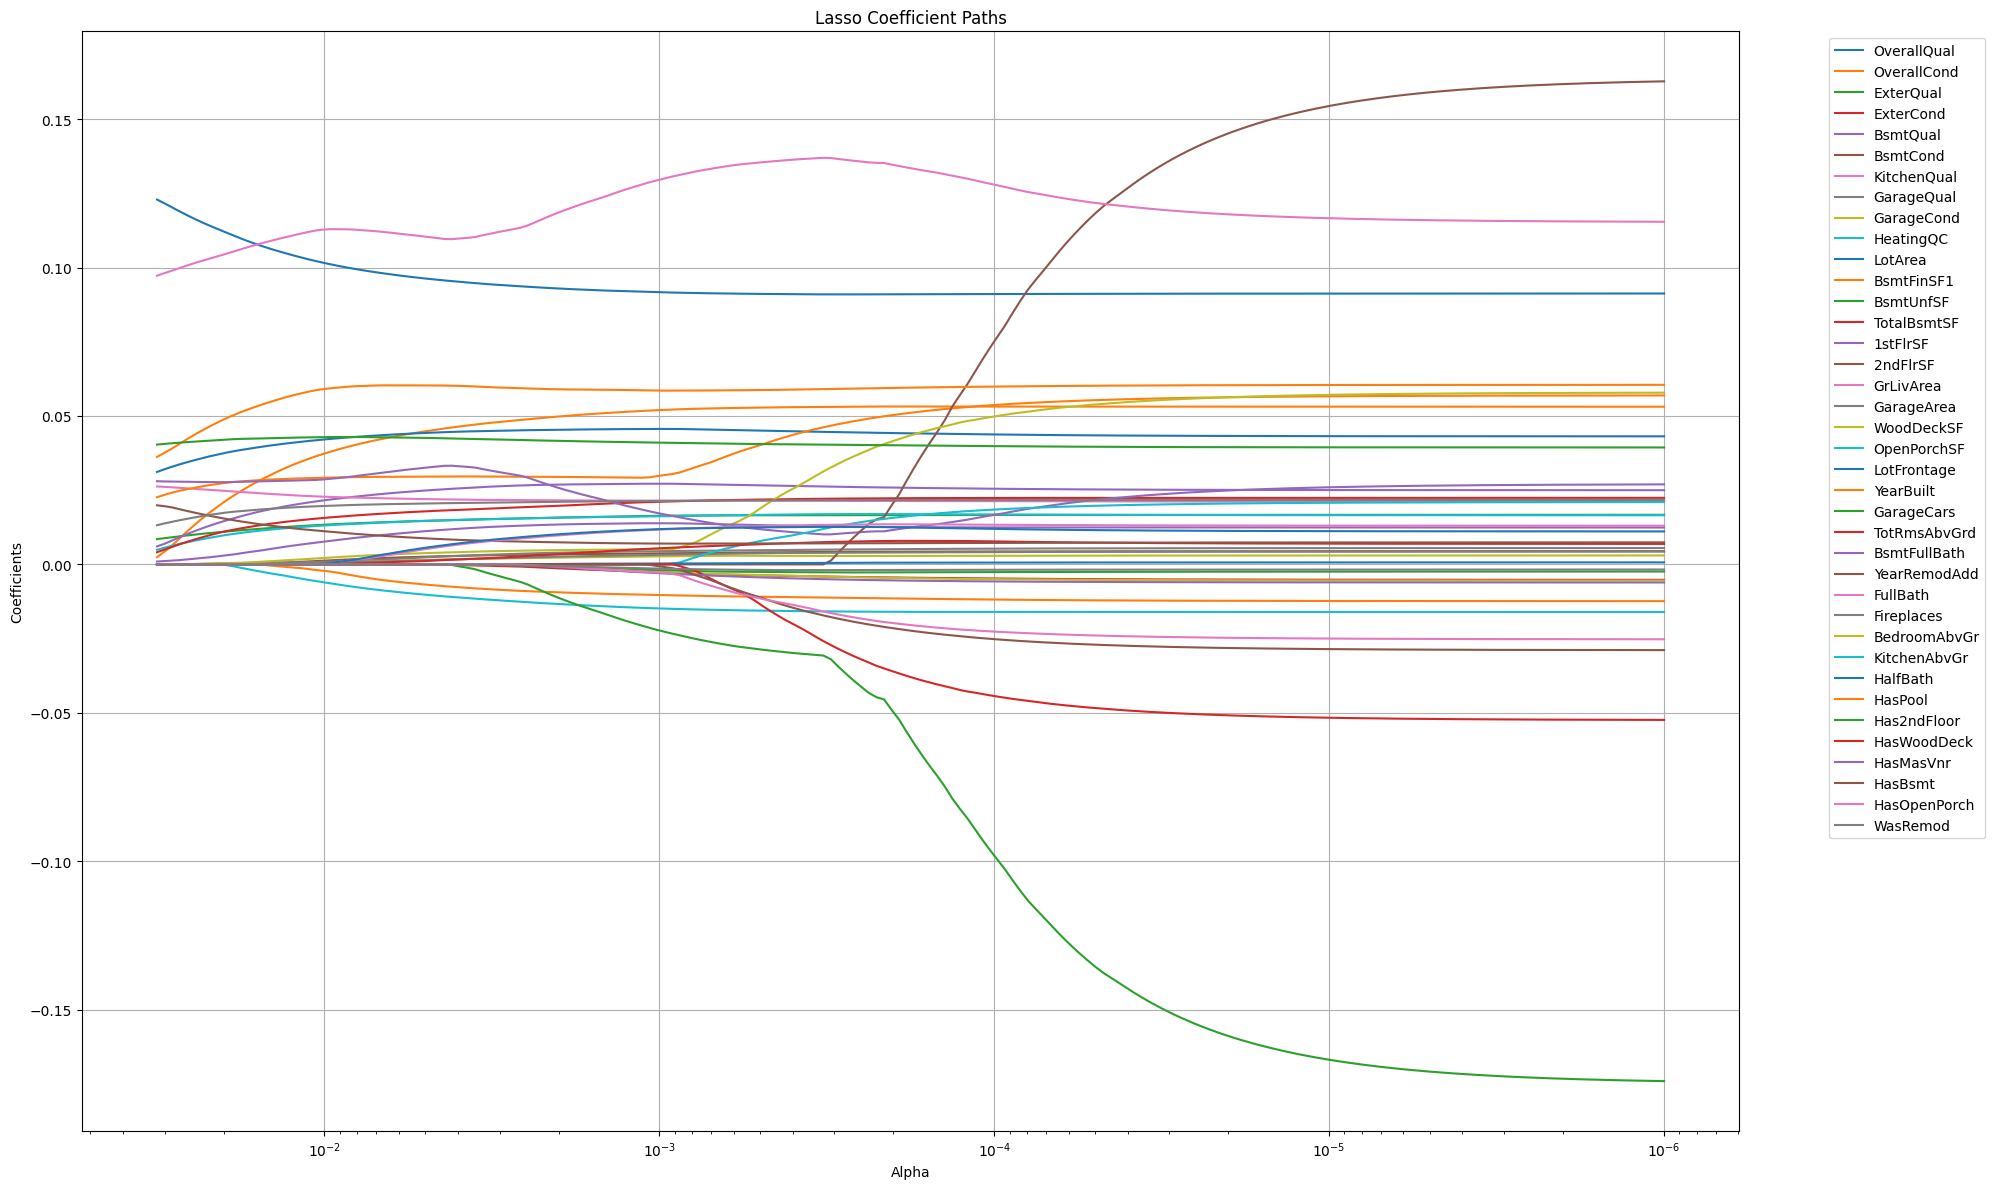

In [92]:
plt.figure(figsize=(20, 12))
for i in range(lasso_coefs.shape[1]):
    plt.plot(lasso_alphas, lasso_coefs[:, i], label=X_train_lin.columns[i])
    
plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficient Paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

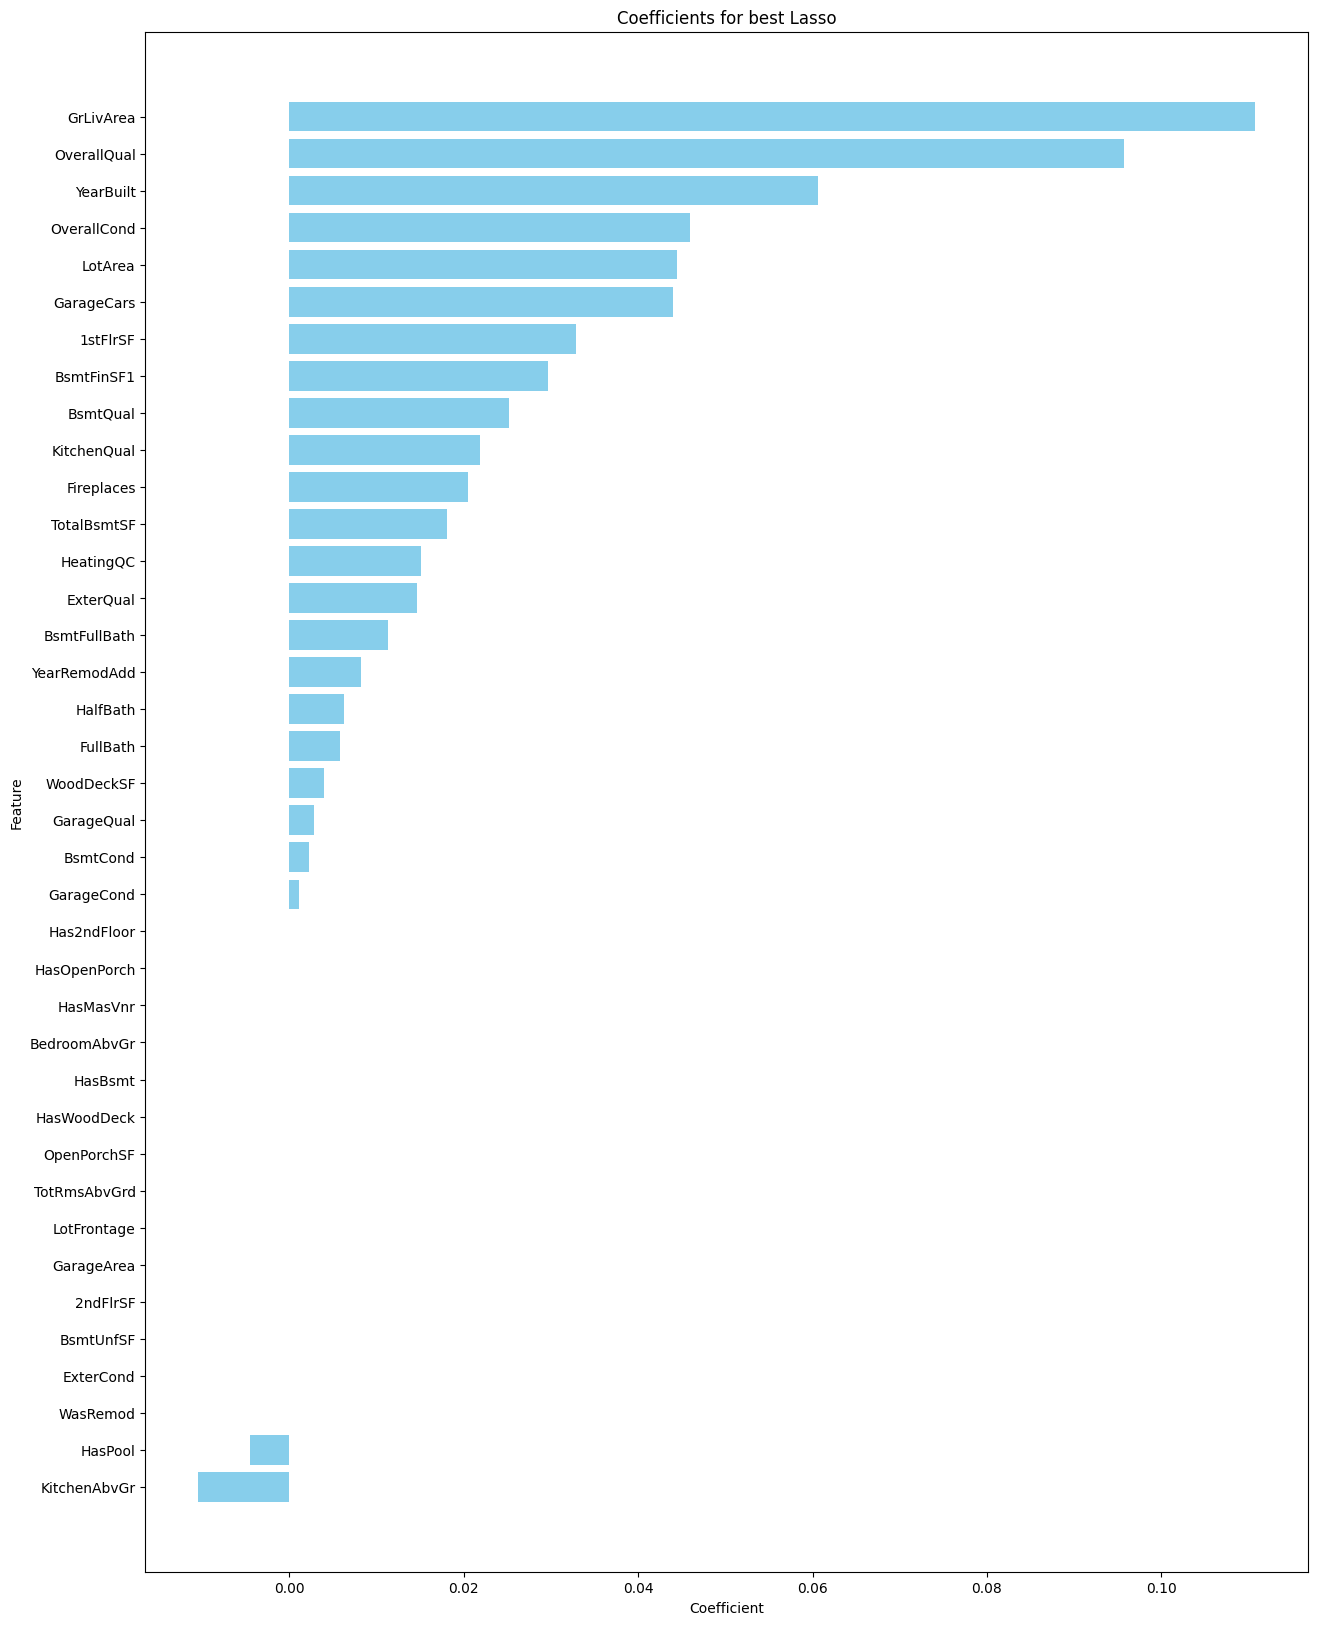

In [44]:
best_lasso_coefs = best_lasso.coef_

lasso_coefs_df = pd.DataFrame({
    'Feature': X_train_lin.columns,
    'Coefficient': best_lasso_coefs
})

lasso_coefs_df = lasso_coefs_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(15, 20))
plt.barh(lasso_coefs_df['Feature'], lasso_coefs_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Coefficients for best Lasso')
plt.gca().invert_yaxis()  

plt.show()

Lasso CV does not select the area features with 'HasX' associated binary feature, probably due to instability caused by collinearity. We will re-add these in the second stage when we attempt to use non-linear models.

In [54]:
columns_to_readd = ['Has2ndFloor', 'HasOpenPorch', 'HasMasVnr', 'BedroomAbvGr', 'HasBsmt', 'HasWoodDeck', 'OpenPorchSF', 'TotRmsAbvGrd', 'LotFrontage', 'GarageArea', '2ndFlrSF', 'ExterCond', 'WasRemod', 'HasPool', 'KitchenAbvGr']

## Ridge

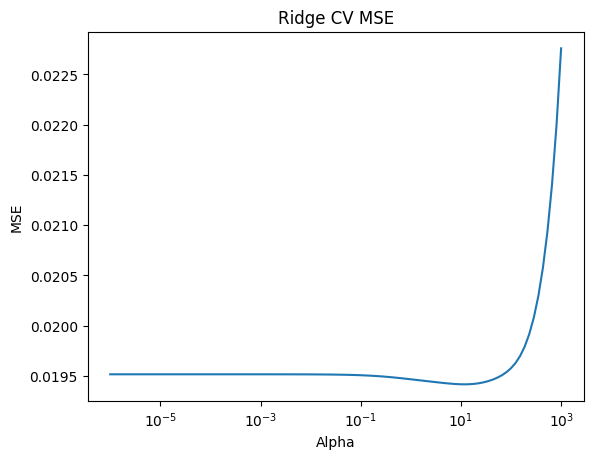

In [55]:
from sklearn.linear_model import Ridge

ridge = Ridge(max_iter = 7000)
ridge_alphas = np.logspace(-6, 3, 100)

best_alpha_ridge, best_error_ridge, ridge_cv_errors, ridge_coefs = custom_cv(ridge, X_train_scaled, y_train_lin, ridge_alphas)

plt.plot(ridge_alphas, ridge_cv_errors)
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('Ridge CV MSE')
plt.show()

In [56]:
print(f"Best alpha Ridge: {best_alpha_ridge}")
print(f"Best RMSE Ridge: {np.sqrt(best_error_ridge)}")

Best alpha Ridge: 12.32846739442066
Best RMSE Ridge: 0.13934304887230065


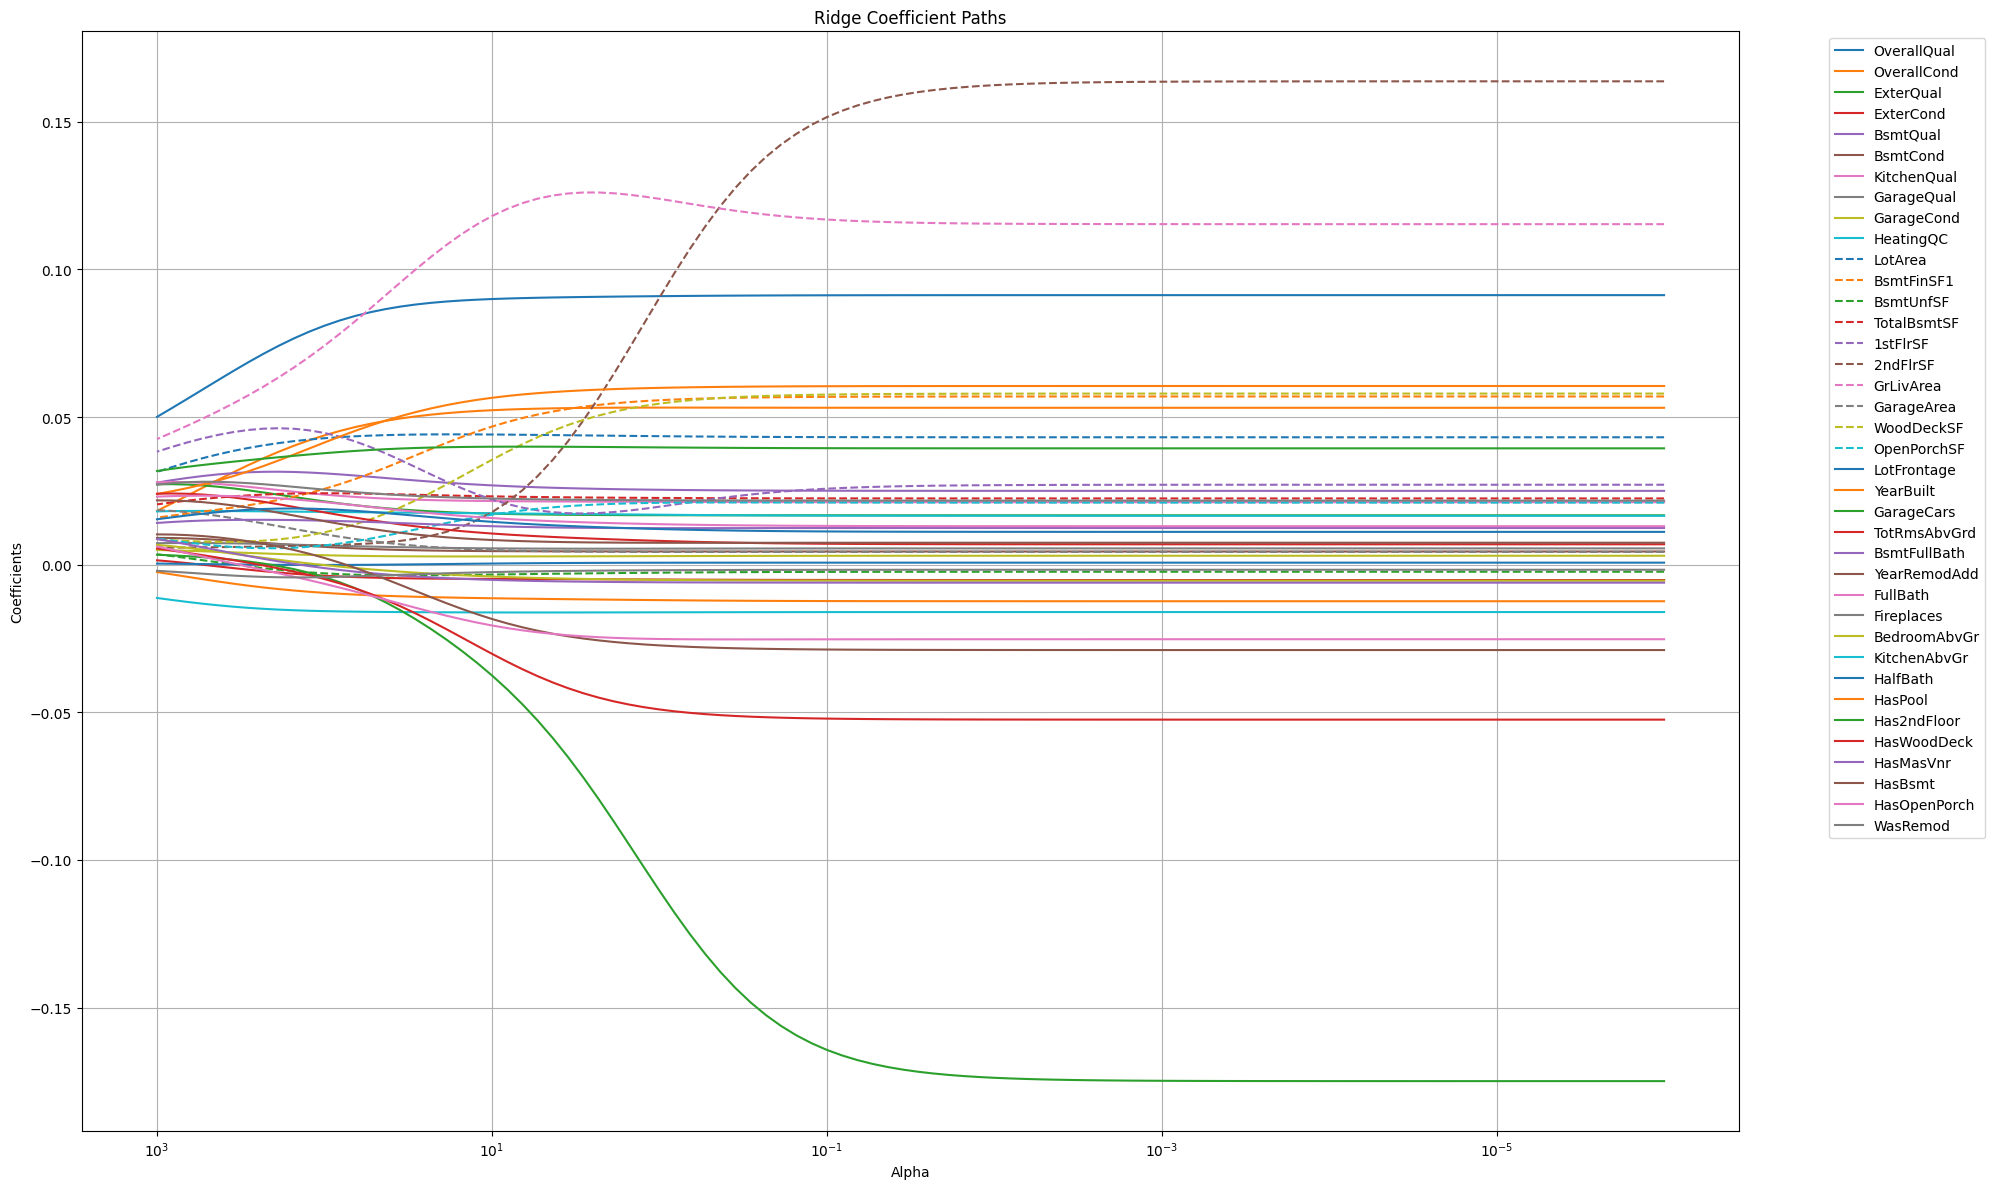

In [57]:
from matplotlib.cm import get_cmap

plt.figure(figsize=(20, 12))

for i in range(ridge_coefs.shape[1]):
    if i < 10:
        linestyle = '-'  # Solid lines for the first 10
    elif i < 20:
        linestyle = '--'  # Dashed lines for the next 10
    else:
        linestyle = '-'  # If more than 20 lines, start over with solid
    plt.plot(ridge_alphas, ridge_coefs[:, i], label=X_train_lin.columns[i], linestyle=linestyle)

plt.xscale('log')
plt.gca().invert_xaxis()
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficient Paths')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

10-fold CV with Ridge and Lasso suggests robust and not overfitted predictions with OLS. 

One surprising observation is that OLS gives negative coefficients to GarageArea and TotRmsAbvGrd despite these being correlated with SalePrice (ExterCond almost had no correlation to target to begin with). We can hypothesize that this is due to poor space utilization -- too large of a garage relative to living area or too many rooms in a small space. Let's test this hypothesis by checking the correlation of with the target of garage_frac (fraction of living space taken by the garage) and room_size_inv (inverse of the room sizes).

Text(0, 0.5, 'logSalePrice')

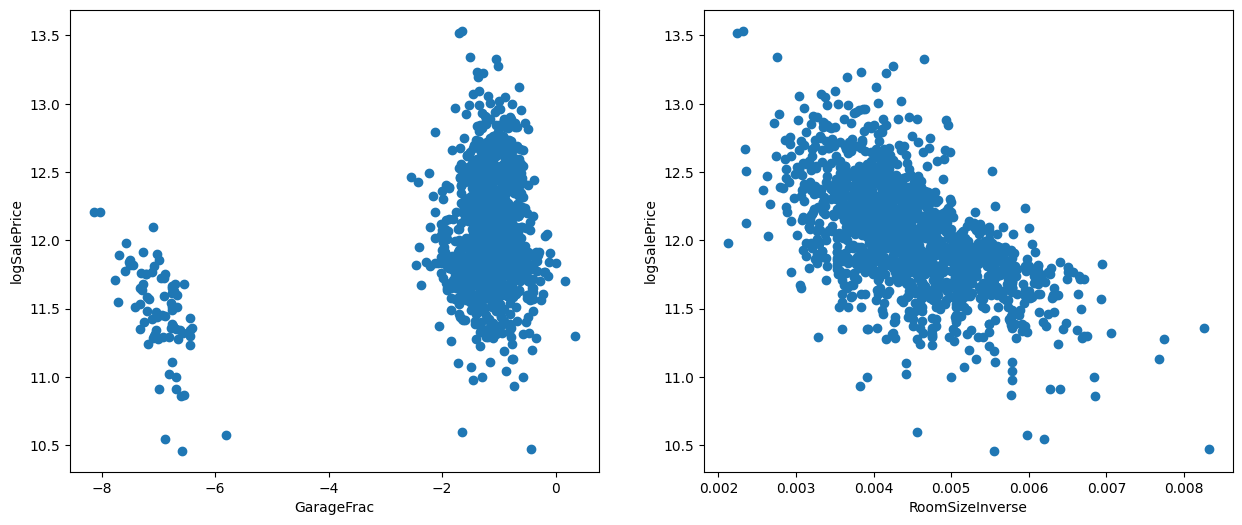

In [58]:
garage_frac = X_train_lin['GarageArea']-X_train_lin['GrLivArea'] #Take difference here for ratio since features are log transformed.
room_size_inv = X_train_lin['TotRmsAbvGrd']/(np.exp(X_train_lin['GrLivArea'])) #Take exp of GrLivArea to be meaningful since it was previously log transformed.

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(x = garage_frac, y = y_train_lin)
axes[1].scatter(x = room_size_inv, y = y_train_lin)
axes[0].set_xlabel("GarageFrac")
axes[1].set_xlabel("RoomSizeInverse")
axes[0].set_ylabel("logSalePrice")
axes[1].set_ylabel("logSalePrice")

# Stage 2: Random Forest for Residuals

## Preprocessing (again)

In [45]:
non_lin_cols = list(set(train_df.columns).difference(set(X_train_lin.columns).difference({'SalePrice', 'logSalePrice'})))
train_df[non_lin_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotConfig      1460 non-null   object 
 1   MoSold         1460 non-null   object 
 2   MasVnrArea     1452 non-null   float64
 3   Utilities      1460 non-null   object 
 4   RoofMatl       1460 non-null   object 
 5   BsmtFinSF2     1460 non-null   int64  
 6   SalePrice      1460 non-null   int64  
 7   RoofStyle      1460 non-null   object 
 8   Condition2     1460 non-null   object 
 9   FireplaceQu    770 non-null    object 
 10  Heating        1460 non-null   object 
 11  DateSoldMos    1460 non-null   object 
 12  LowQualFinSF   1460 non-null   int64  
 13  LandContour    1460 non-null   object 
 14  MiscVal        1460 non-null   object 
 15  GarageFinish   1379 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  Electrical     1459 non-null   object 
 18  MSZoning

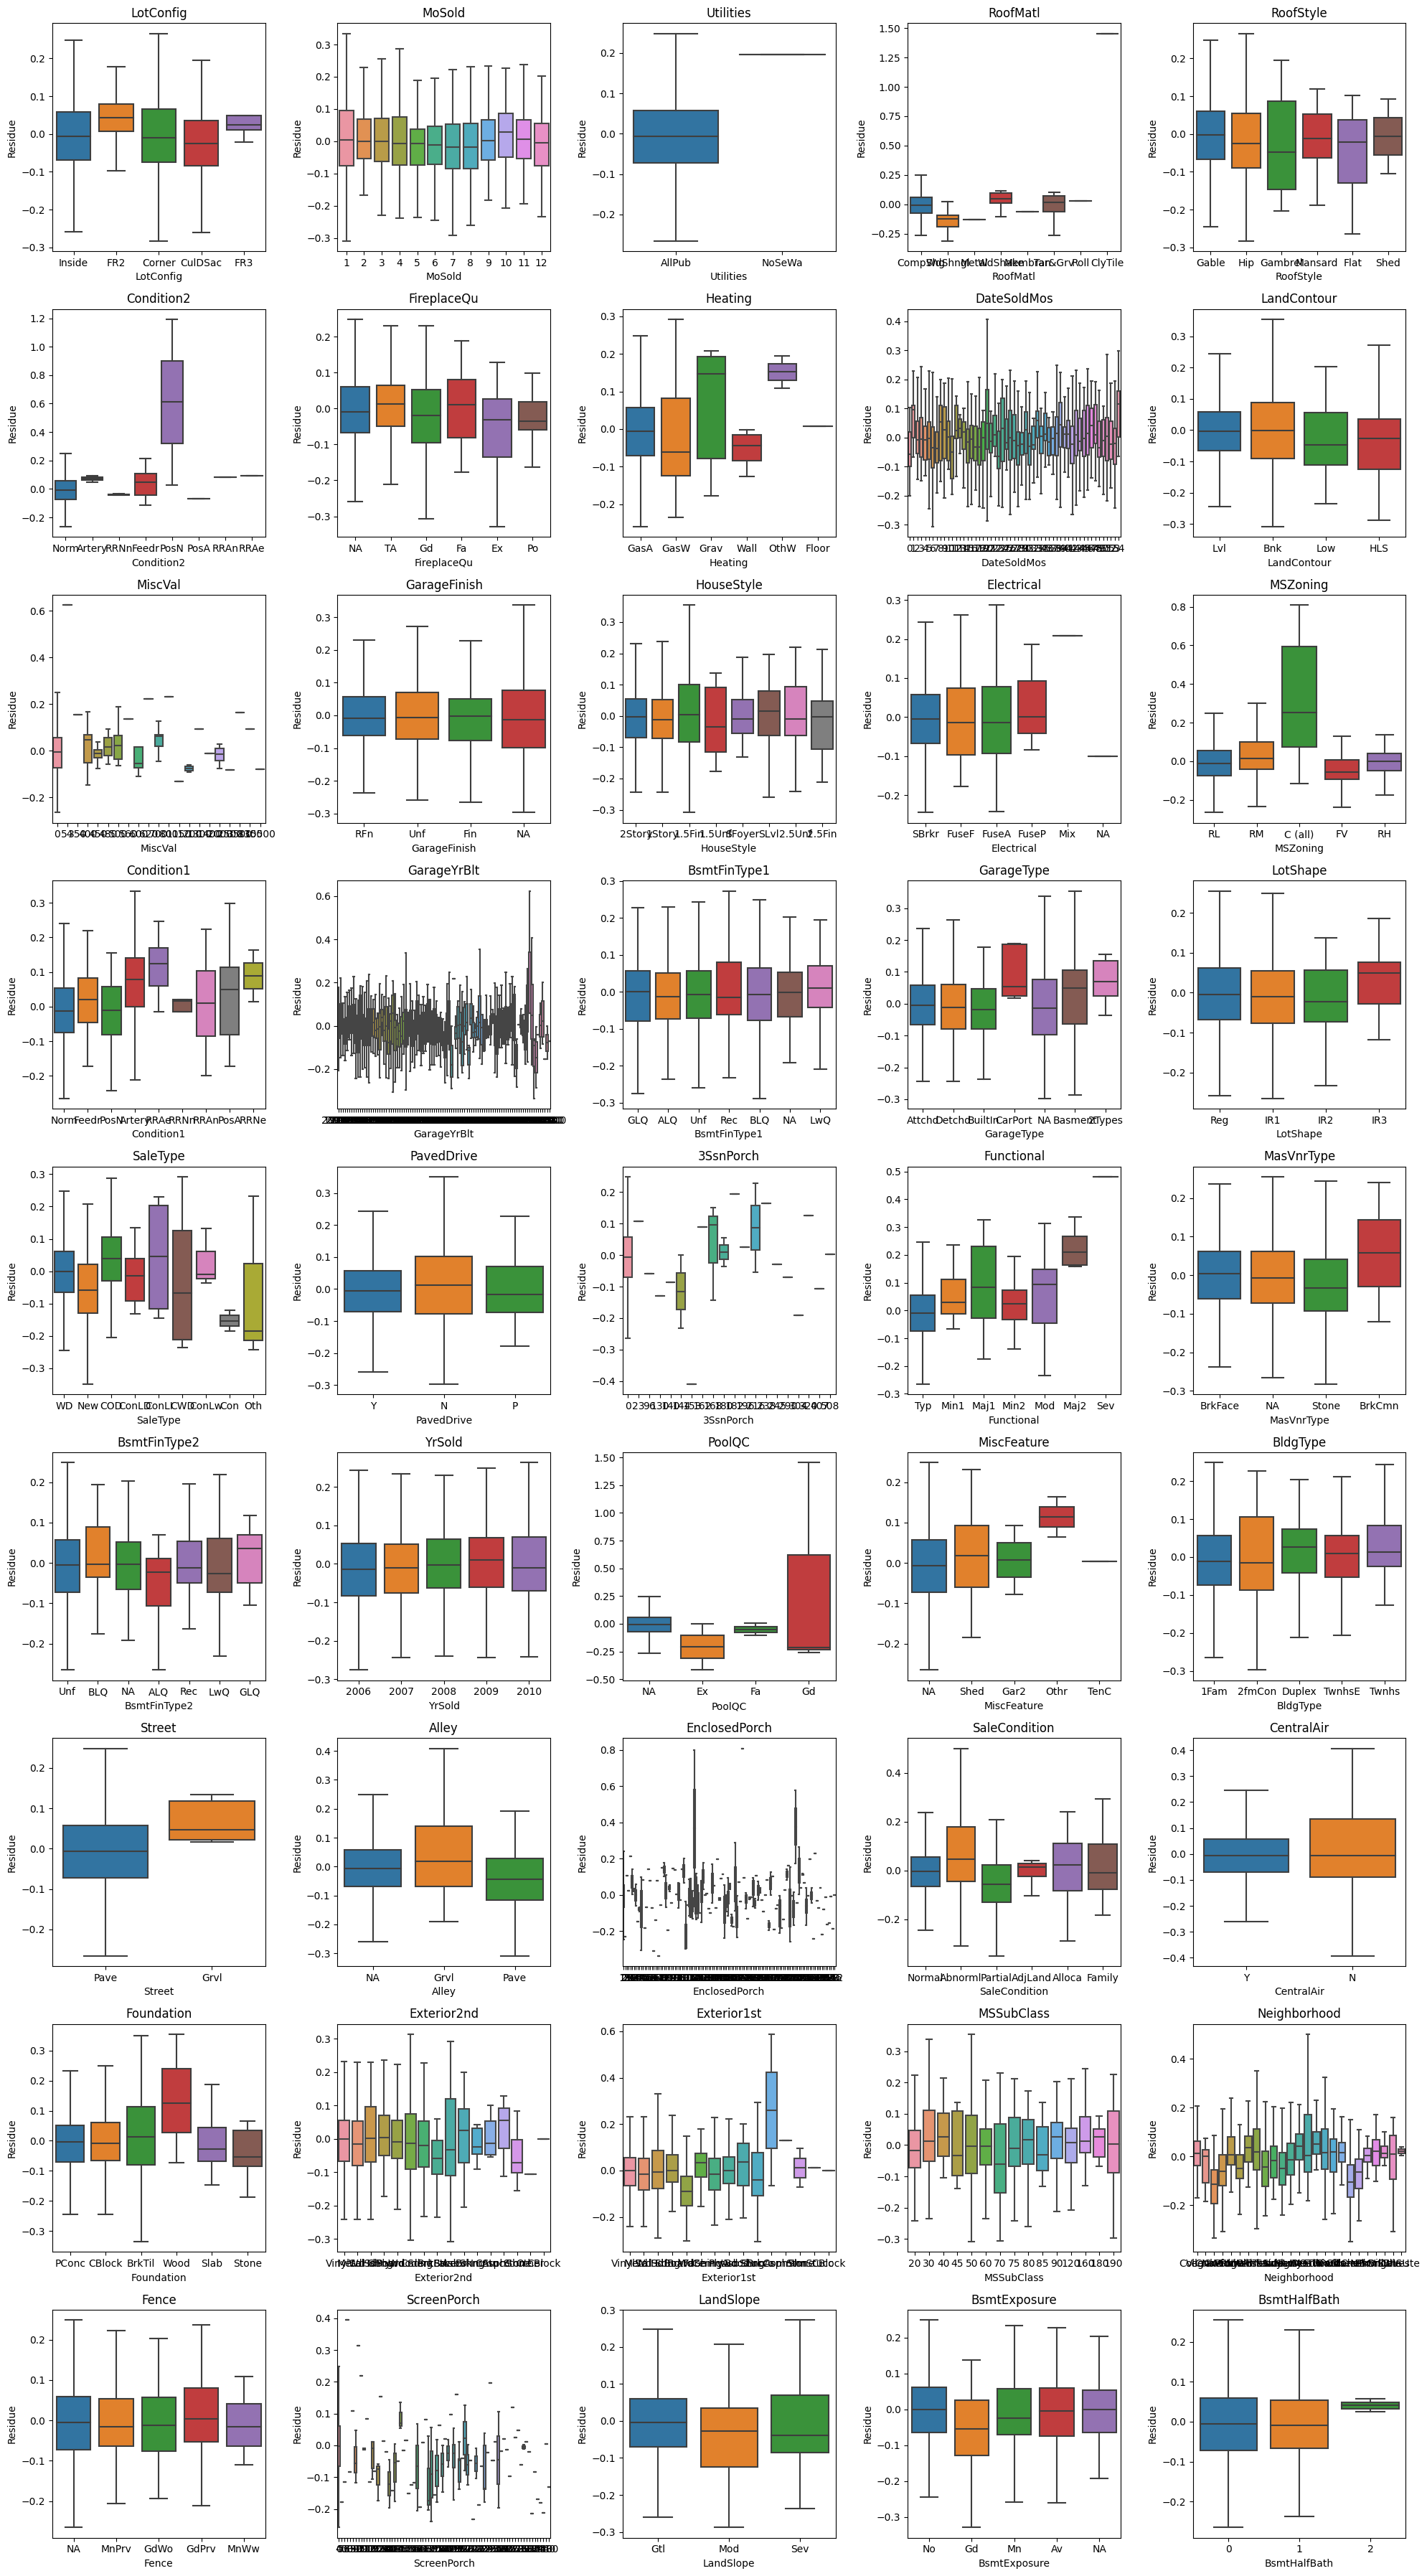

In [46]:
train_df['Residue'] = lasso_residues

categorical_cols = train_df[non_lin_cols].select_dtypes(include = ['object']).columns
plots_per_row = 5
num_rows = (len(categorical_cols) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4))

axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    train_df_copy = train_df
    train_df_copy[col] = train_df_copy[col].fillna('NA')
    sns.boxplot(x = col, y = 'Residue', data = train_df_copy, showfliers = False, ax = axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Remove redundant features and features with too many missing values and no correlation to residues:

In [142]:
categorical_cols = ['Neighborhood', 'SaleType', 'Foundation', 'MoSold', 'Condition1', 'Street', 'HouseStyle', 'BldgType', 'MSZoning', 'Alley', 'Exterior1st', 'BsmtExposure', 'MSSubClass', 'Fence', 'LandSlope', 'MasVnrType', 'LotShape', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd']

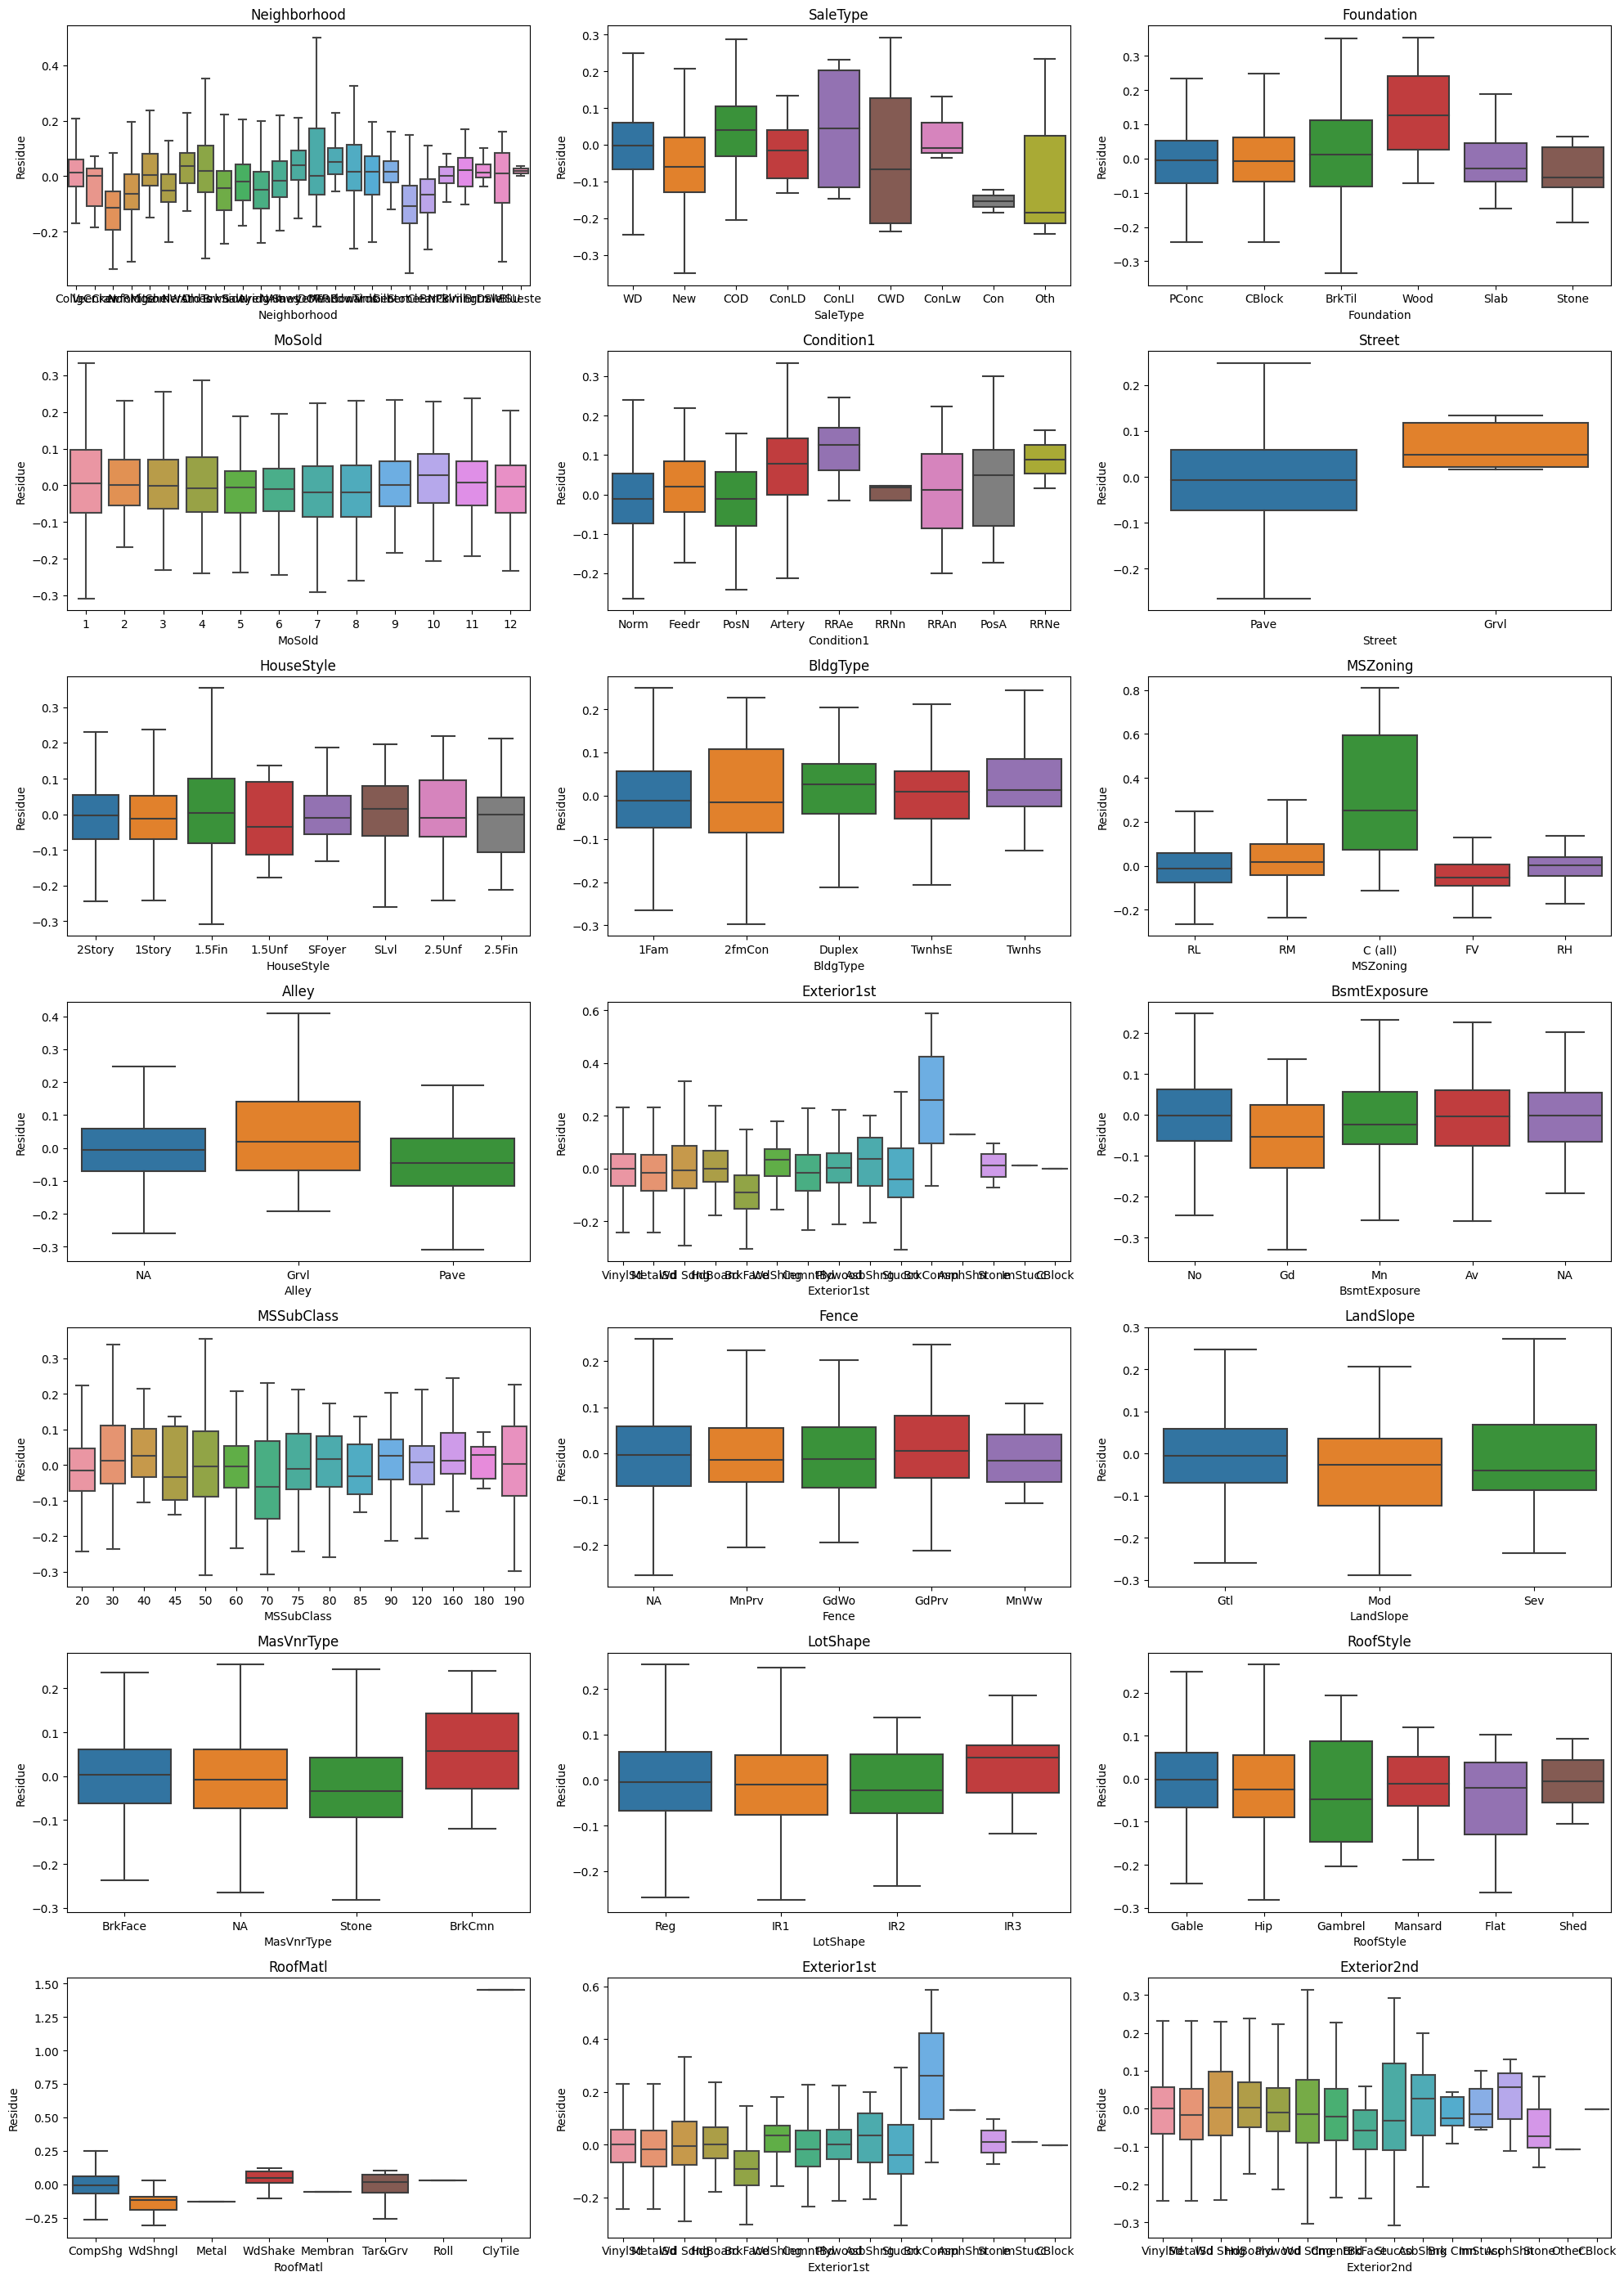

In [143]:
plots_per_row = 3
num_rows = (len(categorical_cols) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(20, num_rows * 4))

axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    train_df_copy = train_df
    train_df_copy[col] = train_df_copy[col].fillna('NA')
    sns.boxplot(x = col, y = 'Residue', data = train_df_copy, showfliers = False, ax = axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Reanalyze remaining numerical features:

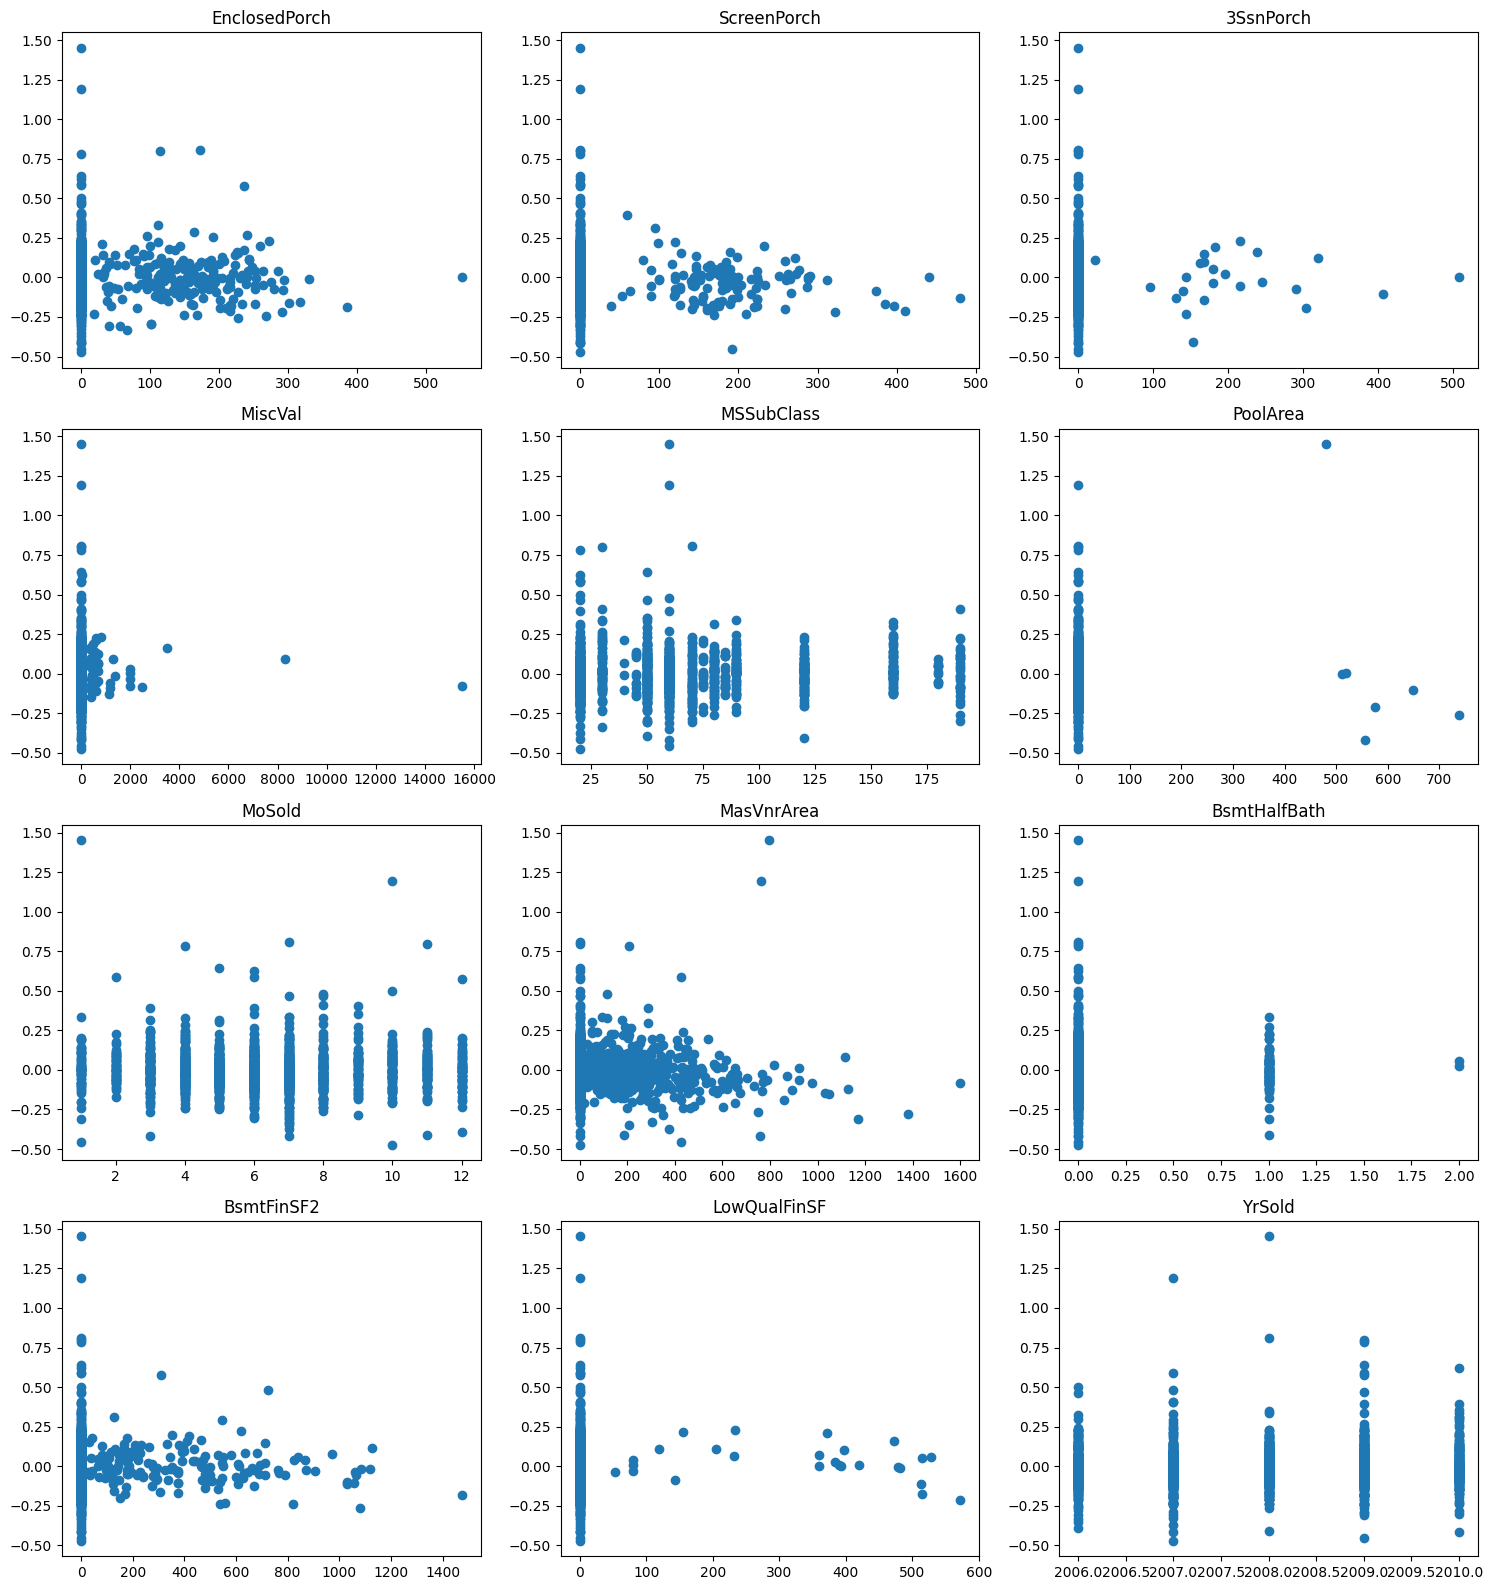

In [63]:
numerical_cols = train_df[non_lin_cols].select_dtypes(include = ['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['SalePrice', 'logSalePrice', 'DateSoldMos']]
plots_per_row = 3
num_rows = (len(numerical_cols) + plots_per_row - 1) // plots_per_row
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, num_rows * 4))

axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    train_df_copy = train_df
    train_df_copy[col] = train_df[col].fillna(0)
    axes[i].scatter(x = col, y = 'Residue', data = train_df_copy)
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [64]:
train_df[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EnclosedPorch  1460 non-null   int64  
 1   ScreenPorch    1460 non-null   int64  
 2   3SsnPorch      1460 non-null   int64  
 3   MiscVal        1460 non-null   int64  
 4   MSSubClass     1460 non-null   int64  
 5   PoolArea       1460 non-null   int64  
 6   MoSold         1460 non-null   int64  
 7   MasVnrArea     1460 non-null   float64
 8   BsmtHalfBath   1460 non-null   int64  
 9   BsmtFinSF2     1460 non-null   int64  
 10  LowQualFinSF   1460 non-null   int64  
 11  YrSold         1460 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 137.0 KB


In [65]:
test_df[numerical_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   EnclosedPorch  1459 non-null   int64  
 1   ScreenPorch    1459 non-null   int64  
 2   3SsnPorch      1459 non-null   int64  
 3   MiscVal        1459 non-null   int64  
 4   MSSubClass     1459 non-null   int64  
 5   PoolArea       1459 non-null   int64  
 6   MoSold         1459 non-null   int64  
 7   MasVnrArea     1444 non-null   float64
 8   BsmtHalfBath   1457 non-null   float64
 9   BsmtFinSF2     1458 non-null   float64
 10  LowQualFinSF   1459 non-null   int64  
 11  YrSold         1459 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 136.9 KB


In [66]:
test_df[numerical_cols] = test_df[numerical_cols].fillna(0)

None of the remaining numerical features have any noticeable correlation with the residues, so we will proceed with only the categorical features.

In [144]:
from sklearn.preprocessing import OneHotEncoder

train_df_cat = train_df[categorical_cols]
test_df_cat = test_df[categorical_cols]

train_df_cat = train_df_cat.fillna('NA')
test_df_cat = test_df_cat.fillna('NA')

encoder = OneHotEncoder(drop ='first', sparse_output = False, handle_unknown = 'ignore', min_frequency = 5)
encoder.fit(train_df_cat)
col_names = encoder.get_feature_names_out(categorical_cols)

array_train_enc = encoder.transform(train_df_cat)
X_train_enc = pd.DataFrame(array_train_enc, columns = col_names)

array_test_enc = encoder.transform(test_df_cat)
X_test_enc = pd.DataFrame(array_test_enc, columns = col_names)

y_train = train_df['Residue']

In [145]:
encoder.get_feature_names_out()

array(['Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill',
       'Neighborhood_NWAmes', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhood_SawyerW', 'Neighborhood_Somerst',
       'Neighborhood_StoneBr', 'Neighborhood_Timber',
       'Neighborhood_Veenker', 'Neighborhood_infrequent_sklearn',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw',
       'SaleType_New', 'SaleType_WD', 'SaleType_infrequent_sklearn',
       'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Slab',
       'Foundation_Stone', 'Foundation_infrequent_sklearn', 'MoSold_2',
       'MoSold_3', 'MoSold_4', 'MoSold_5', 'MoSold_6', 'MoSold_7',
  

Re-add columns that Lasso did not account for.

In [146]:
X_train_enc['ExcessLot'] = X_train_lin['LotArea'].apply(lambda x: max(0, x-10))
X_test_enc['ExcessLot'] = X_test_lin['LotArea'].apply(lambda x: max(0, x-10))
X_train_enc[columns_to_readd] = X_train_lin[columns_to_readd]
X_test_enc[columns_to_readd] = X_test_lin[columns_to_readd]

In [147]:
X_train_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 160 entries, Neighborhood_BrDale to KitchenAbvGr
dtypes: float64(153), int64(7)
memory usage: 1.8 MB


## Fitting and Prediction

In [136]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

param_grid = {
    'n_estimators': [200, 300, 400],  
    'max_depth': [5, 10, 20, 30],  
    'min_samples_split': [2, 3, 5],  
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

grid_search.fit(X_train_enc, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best CV RMSE: ", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


KeyboardInterrupt: 

In [148]:
rf_regressor = RandomForestRegressor(bootstrap= False, max_depth= 30, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)
rf_regressor.fit(X_train_enc, y_train)

res_train_pred = rf_regressor.predict(X_train_enc)
rf_res_test_pred = rf_regressor.predict(X_test_enc)

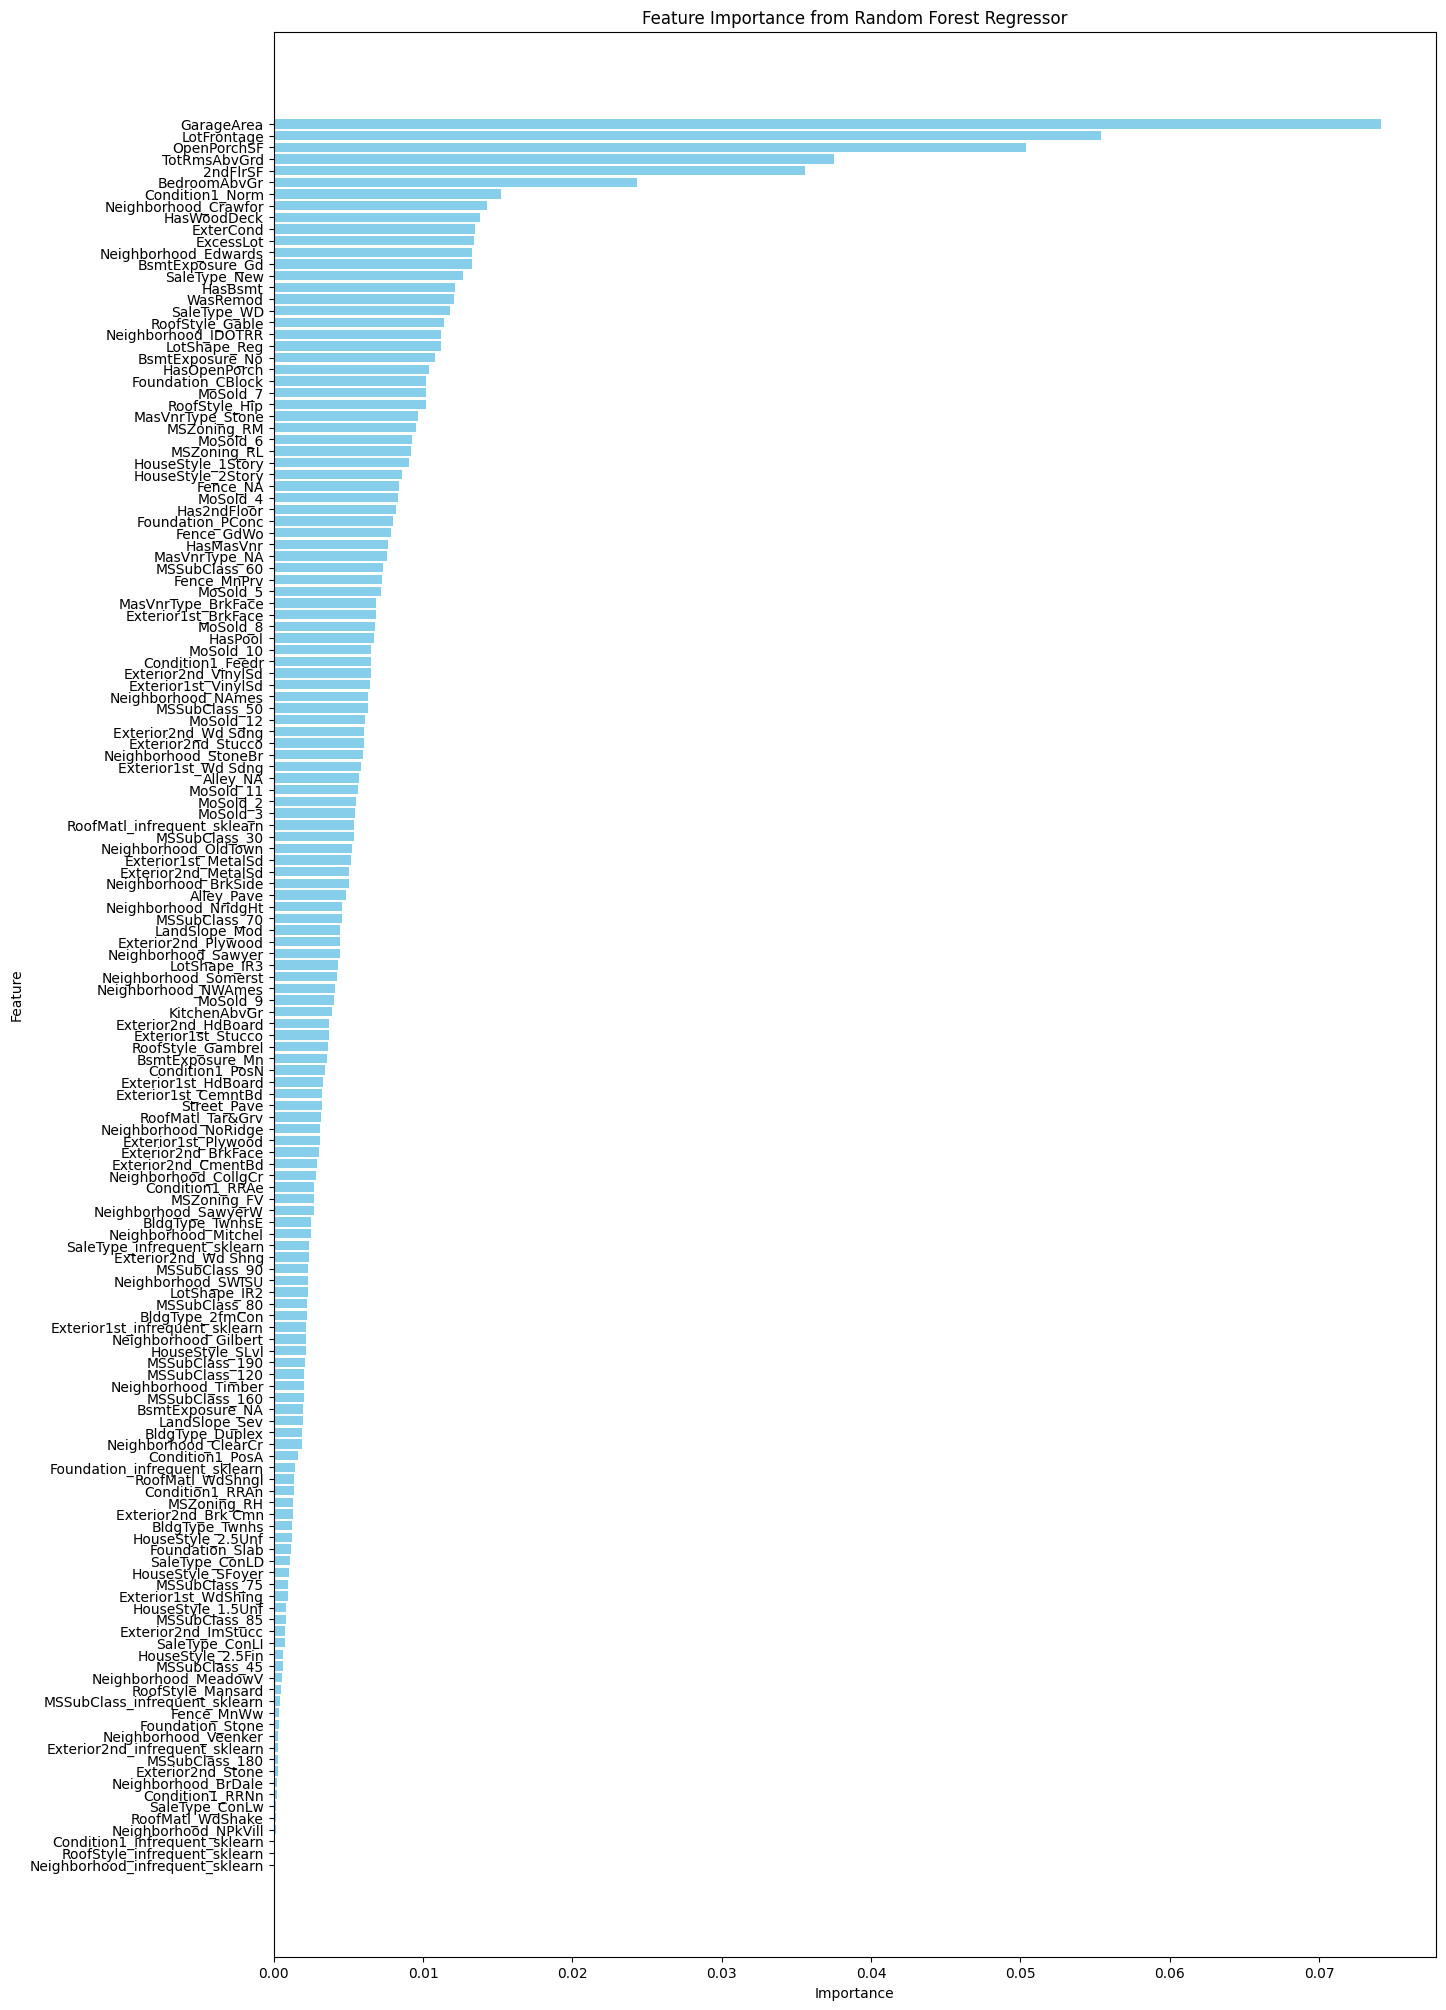

In [149]:
importances = rf_regressor.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train_enc.columns,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(15, 25))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Regressor')
plt.gca().invert_yaxis()  

plt.show()

In [150]:
y_train_pred = y_train_lasso_pred - res_train_pred
np.sqrt(mean_squared_error(y_train_pred, train_df['logSalePrice']))

0.015517268012759444

## RFE for Random Forest

In [173]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

def rfe_with_cv(estimator, X, y, cv_folds=5, step=1, scoring='neg_mean_squared_error'):
    
    rfe = RFE(estimator, n_features_to_select=1, step=step)
    rfe.fit(X, y)
    ranking = rfe.ranking_
    sorted_features = np.argsort(ranking)

    best_score = -np.inf
    best_num_features = 0
    best_features = []
    errors_vs_features = []
    training_errors_vs_features = []

    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for i in range(1, len(sorted_features) + 1):
        selected_features = sorted_features[:i]
        X_selected = X.iloc[:, selected_features]

        cv_scores = cross_val_score(estimator, X_selected, y, cv=cv, scoring=scoring, n_jobs=-1)
        mean_cv_score = cv_scores.mean()
        
        estimator.fit(X_selected, y)
        train_pred = estimator.predict(X_selected)
        train_error = -np.mean((y - train_pred) ** 2)  

        errors_vs_features.append(np.sqrt(-mean_cv_score)) 

        training_errors_vs_features.append(np.sqrt(-train_error))

        if mean_cv_score > best_score:
            best_score = mean_cv_score
            best_num_features = i
            best_features = X.columns[selected_features].tolist()
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(sorted_features) + 1), errors_vs_features, label='Cross-Validated RMSe')
    plt.plot(range(1, len(sorted_features) + 1), training_errors_vs_features, label='Training RMSE')
    plt.xlabel('Number of Features')
    plt.ylabel('RMSE')
    plt.title('RMSE vs n_features')
    plt.legend()
    plt.grid(True)
    plt.show()

    return best_num_features, best_features, best_score, errors_vs_features, training_errors_vs_features


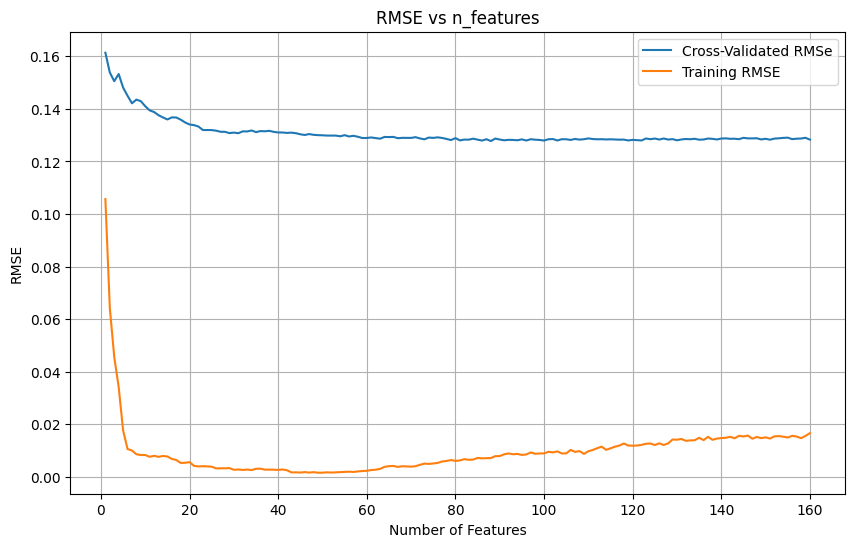

In [174]:
rf_best = RandomForestRegressor(bootstrap= False, max_depth= 30, max_features= 'log2', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)
best_num_features, best_features, best_score, cv_errors_list, training_errors_list = rfe_with_cv(rf_best, X_train_enc, y_train, scoring='neg_mean_squared_error')

In [181]:
X_train_select = X_train_enc[best_features[:50]]
X_test_select = X_test_enc[best_features[:50]]

rf_best.fit(X_train_select, y_train)
rf_select_test_residues = rf_best.predict(X_test_select)

## Attempt with Gradient Boosted Decision Trees

In [ ]:
from xgboost import XGBRegressor

xgb_param_grid = {
        'n_estimators': [100, 200, 300], 
        'learning_rate': [0.01, 0.05], 
        'max_depth': [3, 5, 7], 
        'subsample': [0.8, 1.0],  
        'colsample_bytree': [0.8, 1.0], 
        'reg_alpha': [0, 0.1, 0.5],  
        'reg_lambda': [0.1, 1]     
}

xgb = XGBRegressor(enable_categorical = True)

#xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=5, n_jobs=-1, verbose=1)
#xgb_grid_search.fit(X_train_enc, y_train)

#print("Best parameters found: ", xgb_grid_search.best_params_)
#print("Best RMSE: ", xgb_grid_search.best_score_)

In [62]:
xgb_regressor = XGBRegressor(colsample_bytree = 0.8, learning_rate = 0.05, max_depth = 5,  min_child_weight = 1, n_estimators = 100, subsample = 0.8, enable_categorical = True)
xgb_regressor.fit(X_train_enc, y_train)
xgb_res_train = xgb_regressor.predict(X_train_enc)
xgb_res_test = xgb_regressor.predict(X_test_enc)

In [63]:
y_train_pred_xgb = y_train_lasso_pred - xgb_res_train
np.sqrt(mean_squared_error(y_train_pred_xgb, train_df['logSalePrice']))

0.09199325552772268

In [80]:
from catboost import CatBoostRegressor

catboost = CatBoostRegressor(bagging_temperature= 0.1, border_count= 64, depth= 5, iterations= 200, l2_leaf_reg= 1, learning_rate= 0.05, silent=True)
catboost.fit(X_train_enc, y_train)

res_train_cat = catboost.predict(X_train_enc)
res_test_cat =catboost.predict(X_test_enc)

y_train_pred_cat = y_train_lasso_pred - res_train_cat
np.sqrt(mean_squared_error(y_train_pred_cat, train_df['logSalePrice']))

0.09373406575211876

## Attempt with Stacking Regressor

In [ ]:
# from tqdm.notebook import tqdm
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor

# models = {
#     'ridge': Ridge(),
#     'lasso': Lasso(),
#     'lightgbm': LGBMRegressor(verbose = -1),
#     'xgboost': XGBRegressor(),
#     'catboost': CatBoostRegressor(silent=True),
#     'randomforest': RandomForestRegressor()
# }

# param_grids = {
#     'ridge': {
#         'alpha': np.logspace(-5, 2, 50),  
#         'max_iter': [30000],  
#     },
#     'lasso': {
#         'alpha': np.logspace(-6, 0, 50),  
#         'max_iter': [30000],  
#     },
#     'lightgbm': {
#         'num_leaves': [31, 50, 70],  
#         'learning_rate': [0.005, 0.01, 0.05],  
#         'n_estimators': [100, 200, 500],  
#         'subsample': [0.6, 0.8, 1.0],  
#         'colsample_bytree': [0.6, 0.8, 1.0]  
#     },
#     'xgboost': {
#         'n_estimators': [100, 200], 
#         'learning_rate': [0.01, 0.05], 
#         'max_depth': [3, 5, 7], 
#         'subsample': [0.8, 1.0],  
#         'colsample_bytree': [0.8, 1.0], 
#         'reg_alpha': [0, 0.1, 0.5],  
#         'reg_lambda': [0.1, 1]  
#     },
#     'catboost': {
#         'iterations': [100, 200],  
#         'learning_rate': [0.01, 0.05], 
#         'depth': [3, 5, 7],  
#         'l2_leaf_reg': [1, 3, 5],  
#         'bagging_temperature': [0.1, 0.5, 1.0],  
#         'border_count': [32, 64, 128]  
#     },
#     'randomforest': {
#         'n_estimators': [100, 200, 500], 
#         'max_depth': [None, 10, 20],  
#         'min_samples_split': [2, 5, 10], 
#         'min_samples_leaf': [1, 2, 4],  
#         'max_features': ['sqrt', 'log2'],  
#         'bootstrap': [True, False] 
#     }
# }

# best_models = {}
# best_scores = []
# best_params = {}
# best_rmse_scores = []

# for model_name in tqdm(models):
#     grid_search = GridSearchCV(
#         estimator=models[model_name],
#         param_grid=param_grids[model_name],
#         cv=5,
#         n_jobs=-1,
#         scoring='neg_mean_squared_error',
#         verbose=1
#     )
#     grid_search.fit(X_train_enc, y_train)
    
#     best_neg_mse = grid_search.best_score_
#     best_rmse = np.sqrt(-best_neg_mse)
    
#     best_rmse_scores.append(best_rmse)
#     best_params[model_name] = grid_search.best_params_
#     best_models[model_name] = grid_search.best_estimator_

# plt.figure(figsize=(10, 6))
# plt.bar(models.keys(), best_rmse_scores, color='skyblue')
# plt.ylabel('Best RMSE')
# plt.title('Best RMSE for Each Model')
# plt.xticks(rotation=45)
# plt.show()

# print("Best parameters for each model:")
# for model_name, params in best_params.items():
#     print(f"{model_name}: {params}")

'ridge': {'alpha': 19.306977288832496, 'max_iter': 30000}

'lasso': {'alpha': 0.000868511373751352, 'max_iter': 30000} 

'lightgbm': {'colsample_bytree': 0.8, 'learning_rate': 0.005, 'n_estimators': 500, 'num_leaves': 31, 'subsample': 0.6}

'xgboost': {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 0.1, 'subsample': 1.0}

'catboost': {'bagging_temperature': 0.1, 'border_count': 64, 'depth': 5, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.05}

'randomforest': {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}}

In [64]:
# from sklearn.ensemble import StackingRegressor

# stacking_regressor = StackingRegressor(
#     estimators=[
#         ('ridge', Ridge(**best_params['ridge'])),
#         ('lasso', Lasso(**best_params['lasso'])),
#         ('lightgbm', LGBMRegressor(**best_params['lightgbm'], verbose = -1)),
#         ('xgboost', XGBRegressor(**best_params['xgboost'])),
#         ('catboost', CatBoostRegressor(**best_params['catboost'], silent=True)),
#         ('randomforest', RandomForestRegressor(**best_params['randomforest']))
#     ],
#     final_estimator=Ridge(), 
#     passthrough=False, 
#     n_jobs=-1  
# )

# stacking_regressor.fit(X_train_enc, y_train)
# stacking_test_res_pred = stacking_regressor.predict(X_test_enc)

In [65]:
# weights = stacking_regressor.final_estimator_.coef_

# model_weights = {name: weight for name, weight in zip([name for name in models], weights)}

# print("Model Weights in Stacking Regressor:")
# for model_name, weight in model_weights.items():
#     print(f"{model_name}: {weight}")

Model Weights in Stacking Regressor:
ridge: 0.0025998401760057937
lasso: 0.016613058382011717
lightgbm: 0.10670229404898456
xgboost: 0.15590481676278944
catboost: 0.4995576814493247
randomforest: 0.2937499292698195


In [66]:
# stacking_train_res_pred = stacking_regressor.predict(X_train_enc)
# y_train_pred_stacking = y_train_lasso_pred - stacking_train_res_pred
# np.sqrt(mean_squared_error(y_train_pred_stacking, train_df['logSalePrice']))

0.06269245884404277

The trusty RandomForest outperforms the GBDTs even in ensemble in this case.

# Submission

In [182]:
test_ids = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')['Id']

In [183]:
rf_submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': np.exp(y_test_lasso_pred-rf_select_test_residues)})
rf_submission_df.to_csv("housing_submission_rf.csv", index = False)

#cat_submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': np.exp(y_test_lasso_pred-res_test_cat)})
#cat_submission_df.to_csv("housing_submission_cat.csv", index = False)

#two_stage_stacking_submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': np.exp(y_test_lasso_pred-stacking_res_pred)})
#two_stage_stacking_submission_df.to_csv("housing_submission_stack.csv", index = False)